# eXponential Family Dynamical Systems (XFADS): Large-scale nonlinear Gaussian state-space modeling


<a target="_blank" href="https://colab.research.google.com/github/catniplab/xfads/blob/workshop/workshop/monkey_reaching/main.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<br>A low-rank structured variational autoencoding framework for nonlinear Gaussian state-space graphical models capable of capturing dense covariance structures that are important for learning dynamical systems with predictive capabilities. Furthermore, when applied to neural physiological recordings, our approach is able to learn a dynamical system capable of forecasting population spiking and behavioral correlates from a small portion of single trials.<br>

Beyond inferring smoothed latent trajectories, XFADS leverages some quintessential properties of the Exponential familythe Exponential family, and Probabilistic Graphical Models.

This is a walk-through for the minimal functioning of XFADS applied to spiking neural recordings. We will be building and training a state-space model model of the [MC_Maze](https://neurallatents.github.io/datasets.html) dataset as a benchmark, which is a delayed center-out reaching task with barriers. If you feel more comfortable with a more simple walk-through, you can check the previous examples ([Vanderpol oscilator](https://github.com/catniplab/xfads/blob/workshop/workshop/vanderpol/main.ipynb), and [Linear DS](https://github.com/catniplab/xfads/blob/workshop/workshop/linear_ds/main.ipynb)).

With adequate configs and suitable choices of distributions for the SSM modules (as we will see below), you can fit XFADS on different spans of neural data.<br>

For an in-depth understanding of XFADS, check the paper: [Dowling, Zhao, Park. 2024](https://arxiv.org/abs/2403.01371).

## Installation

Clone the XFADS repo<br>
`git clone https://github.com/catniplab/xfads`

Create the environment<br>
`conda env create -f environment.yaml`<br>

Create a `build-system` for the `xfads` package from the `pyproject.toml` file<br>
`pip install -e .`<br>
After running this for the first time you may need to restart the jupyter kernel so that it recognises the package.

In [5]:
def is_running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_running_in_colab():
    %cd content
    !git clone https://github.com/catniplab/xfads.git
    %cd xfads
    !pip install torch pytorch-lightning scikit-learn matplotlib einops
    !pip install -e .
'''    
else:
    !git clone https://github.com/catniplab/xfads.git
    !pip install pytorch-lightning scikit-learn seaborn hydra-core matplotlib einops nlb-tools dandi
    !pip install -e .
'''

import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import seaborn as sns
import os
import gc

import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as Fn
import pytorch_lightning as lightning

from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, GradientAccumulationScheduler
from pytorch_lightning.strategies import DeepSpeedStrategy
from pytorch_lightning.strategies import DDPStrategy
from pytorch_lightning.plugins.precision import deepspeed

from sklearn.linear_model import Ridge

if is_running_in_colab():
  %cd /content/xfads 

import xfads.utils as utils
import xfads.prob_utils as prob_utils

from xfads import plot_utils

from xfads.ssm_modules.likelihoods import PoissonLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.lightning_trainers import LightningNonlinearSSM, LightningMonkeyReaching
from xfads.smoothers.nonlinear_smoother_causal import NonlinearFilter, LowRankNonlinearStateSpaceModel

from xfads.ssm_modules.prebuilt_models import create_xfads_poisson_log_link

import warnings
warnings.filterwarnings("ignore")

if torch.cuda.is_available():
    # To avoid GPU Memory Fragmentation
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [7]:
# Wher to save all the resulting figures
!mkdir output_figs

mkdir: output_figs: File exists


### Define training and model configuration
Note that some other data-dependent attributes are added to the config dictionary while loading and preparing the data. You may also have to edit those based on the data and other project specifications.

In [10]:
"""config"""

cfg = {
    # --- graphical model --- #
    'n_latents': 40,
    'n_latents_read': 35,

    'rank_local': 15,
    'rank_backward': 5,

    'n_hidden_dynamics': 128,

    # --- inference network --- #
    'n_samples': 25,
    'n_hidden_local': 256,
    'n_hidden_backward': 128,

    # --- hyperparameters --- #
    'use_cd': False,
    'p_mask_a': 0.0,
    'p_mask_b': 0.0,
    'p_mask_apb': 0.0,
    'p_mask_y_in': 0.0,
    'p_local_dropout': 0.4,
    'p_backward_dropout': 0.0,

    # --- training --- #
    'device': 'cpu',
    'data_device': 'cpu',
 
    'lr': 1e-3,
    'n_epochs': 1000,
    'batch_sz': 32,
    'minibatch_sz': 8,
    'use_minibatching': False,

    # --- misc --- #
    'bin_sz': 5e-3,
    'bin_sz_ms': 5,
    
    'n_bins_enc': 140,

    'seed': 1236,
    'default_dtype': torch.float32,
    
    'shuffle_train': True,
    'shuffle_valid': False,
    'shuffle_test': False,
    
    # --- ray --- #
    'n_ray_samples': 10,
}

class Cfg(dict):
    def __getattr__(self, attr):
        if attr in self:
            return self[attr]
        else:
            raise AttributeError(f"'DictAsAttributes' object has no attribute '{attr}'")

cfg = Cfg(cfg)

lightning.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)

Seed set to 1236


### Download the data
Here we are using the [MC_Maze:](https://dandiarchive.org/dandiset/000128?search=mc_maze&pos=4) macaque primary motor and dorsal premotor cortex spiking activity during delayed reaching.

In [ ]:
# Downloading the data from DANDI
! mkdir data
! dandi download DANDI:000128/0.220113.0400 --output-dir ./data

### Process NWB data

In [15]:
# Arranging the data (args: [data_folder_path, binsize, align_event, bins_befor, bins_after])
%run process_nwb.py 'data/000128/sub-Jenkins/' 0.25 5 'move_onset_time' 48 132 'hand' 'vel'

number of neurons: 182
total number of trials: 2869
number of null trials: 574


NaNs found in `self.data`. Dropping 5.57% of points to remove NaNs from `trial_data`.


torch.Size([108, 2])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107])
torch.Size([2294, 180, 182])
torch.Size([2294, 180, 2])
torch.Size([2294])
torch.Size([2294, 2])
torch.Size([2294, 3])
Data splits (train/valid/test) saved into the "data" folder.


### Load the data
Since it's a myth that two or more projects use the exact data format and structure, you will need to write your own data loading and preprocessing pipeline, in case you apply XFADS to your own use case. For this and other examples, we provide ready to use pipelines to load some of the benchmarking datasets.<br>

In [18]:
data_path = 'data/data_{split}_{bin_size_ms}ms.pt'
train_data = torch.load(data_path.format(split='train', bin_size_ms=cfg.bin_sz_ms))
val_data = torch.load(data_path.format(split='valid', bin_size_ms=cfg.bin_sz_ms))
test_data = torch.load(data_path.format(split='test', bin_size_ms=cfg.bin_sz_ms))

train_data.keys()

dict_keys(['y_obs', 'n_bins_obs', 'n_bins_enc', 'n_neurons_obs', 'n_neurons_enc', 'targrt_on_bin', 'go_cue_bin', 'move_onset_bin', 'hand_vel', 'conds', 'true_target'])

In [20]:
# obs: observations
y_train_obs = train_data['y_obs'].type(torch.float32).to(cfg.data_device)[:, :cfg.n_bins_enc, :]
y_valid_obs = val_data['y_obs'].type(torch.float32).to(cfg.data_device)[:, :cfg.n_bins_enc, :]
y_test_obs = test_data['y_obs'].type(torch.float32).to(cfg.data_device)[:, :cfg.n_bins_enc, :]

# l: label
l_train = train_data['hand_vel'][:, :cfg.n_bins_enc, :]
l_valid = val_data['hand_vel'][:, :cfg.n_bins_enc, :]
l_test = test_data['hand_vel'][:, :cfg.n_bins_enc, :]

In [22]:
# Time bins of the occurance of events. One of these, usually the one that was used to align the trials around, has a fixed value.
# IMPORTANT: These event names in this list should be the same as the keys in the train_data Dictionary.
events = ['targrt_on_bin', 'go_cue_bin', 'move_onset_bin']
# Event names that appear on pltos
events_str = ['target\non', 'go cue', 'move\nonset']
# How to mark the time point where the perdection of the latents starts (just in the regime of unrolling the latents from a small number of time bins)
pred_str = ['pred\nstarts']

In [24]:
# b: behaviour
b_train = torch.tensor(np.array([train_data[b] for b in events])).permute(1, 0).type(torch.float32).to(cfg.data_device)[:, :cfg.n_bins_enc]
b_valid = torch.tensor(np.array([val_data[b] for b in events])).permute(1, 0).type(torch.float32).to(cfg.data_device)[:, :cfg.n_bins_enc]
b_test = torch.tensor(np.array([test_data[b] for b in events])).permute(1, 0).type(torch.float32).to(cfg.data_device)[:, :cfg.n_bins_enc]

In [26]:
b_train[b_train < 0] = float('nan')
b_valid[b_valid < 0] = float('nan')
b_test[b_test < 0] = float('nan')

In [28]:
# c: condition
c_train = train_data['conds']
c_valid = val_data['conds']
c_test = test_data['conds']

In [30]:
print("observations -", y_train_obs.shape)
print("labels -", l_train.shape)
print("events -", b_train.shape)

observations - torch.Size([1721, 140, 182])
labels - torch.Size([1721, 140, 2])
events - torch.Size([1721, 3])


In [32]:
'''
In some cases we may have alist of values of a parameter, i.e. movement_onset,
where we have to preserve the correspondence bwtween this parameter and the train/valid/test datasets when shuffled.
IMPORTANT: this means that the "shuffle" parameter in the data loader SHOULD ALWAYS BE SET TO "False", for all regimes.
'''
def sync_permutation(*tensors):
    permutated = ()
    torch.manual_seed(cfg.seed)
    permutation_indcs = torch.randperm(tensors[0].shape[0])
    print(f"permutation indices: {permutation_indcs}")
    for _, tensor in enumerate(tensors):
        permutated += (tensor[permutation_indcs],)
    lightning.seed_everything(cfg.seed, workers=True)
    
    return permutated

if cfg.shuffle_train:
    y_train_obs, l_train, b_train, c_train = sync_permutation(y_train_obs, l_train, b_train, c_train)
if cfg.shuffle_valid:
    y_valid_obs, l_valid, b_valid, c_valid = sync_permutation(y_valid_obs, l_valid, b_valid, c_valid)
if cfg.shuffle_test:
    y_test_obs, l_test, b_test, c_test = sync_permutation(y_test_obs, l_test, b_test, c_test)
    
y_train_dataset = torch.utils.data.TensorDataset(y_train_obs, l_train)
y_val_dataset = torch.utils.data.TensorDataset(y_valid_obs, l_valid)     
y_test_dataset = torch.utils.data.TensorDataset(y_test_obs, l_test)

# IMPORTANT: the "shuffle" parameter in the DataLoader SHOULD ALWAYS BE SET TO "False", for all regimes, because, we already did the sync shuffeling.
# If you are just interested in the observations and labels, without any specification for the time bins of certain events, then you can use it casually.
train_dataloader = torch.utils.data.DataLoader(
    y_train_dataset, batch_size=cfg.batch_sz, num_workers=4, pin_memory=True, shuffle=False
)
valid_dataloader = torch.utils.data.DataLoader(
    y_val_dataset, batch_size=cfg.batch_sz, num_workers=4, pin_memory=True, shuffle=False
)
test_dataloader = torch.utils.data.DataLoader(
    y_test_dataset, batch_size=cfg.batch_sz, num_workers=4, pin_memory=True, shuffle=False
) 

# Data dimensions
n_train_trials, n_bins, n_neurons_obs = y_train_obs.shape
n_valid_trials = y_valid_obs.shape[0]
n_test_trials = y_test_obs.shape[0]

# Append data-related attributes to the config Dictionary.
cfg['n_bins'] = n_bins
# Number of time bins used by the model to infere the latents.
#cfg['n_bins_enc'] = train_data['n_bins_enc']
cfg['n_bins_enc'] = 140
# Number of timesteps used by the model to to predict and unroll the latnt trajectories for n_bins - n_bins_bhv timesteps.
#cfg['n_bins_bhv'] = cfg.n_bins // 4
cfg['n_bins_bhv'] = 40

cfg['n_neurons_obs'] = n_neurons_obs
# Number of top most active neurons used by the model to infere the latents.
cfg['n_neurons_enc'] = n_neurons_obs

cfg = Cfg(cfg)

print(f"# training trials: {n_train_trials}")
print(f"# validation trials: {n_valid_trials}")
print(f"# testing trials: {n_test_trials}")
print(f"# neurons: {n_neurons_obs}")
print(f"# time bins: {train_data['y_obs'].type(torch.float32).to(cfg.data_device).shape[1]}")
print(f"# time bins enc: {cfg.n_bins_enc}")
print(f"# time bins used for forcasting: {cfg.n_bins_bhv}")
print(f"# predicted time bins: {cfg.n_bins_enc - cfg.n_bins_bhv}")

Seed set to 1236


permutation indices: tensor([1440,  756,  170,  ..., 1279,  381,  305])
# training trials: 1721
# validation trials: 286
# testing trials: 287
# neurons: 182
# time bins: 180
# time bins enc: 140
# time bins used for forcasting: 40
# predicted time bins: 100


In [34]:
cfg.keys()

dict_keys(['n_latents', 'n_latents_read', 'rank_local', 'rank_backward', 'n_hidden_dynamics', 'n_samples', 'n_hidden_local', 'n_hidden_backward', 'use_cd', 'p_mask_a', 'p_mask_b', 'p_mask_apb', 'p_mask_y_in', 'p_local_dropout', 'p_backward_dropout', 'device', 'data_device', 'lr', 'n_epochs', 'batch_sz', 'minibatch_sz', 'use_minibatching', 'bin_sz', 'bin_sz_ms', 'n_bins_enc', 'seed', 'default_dtype', 'shuffle_train', 'shuffle_valid', 'shuffle_test', 'n_ray_samples', 'n_bins', 'n_bins_bhv', 'n_neurons_obs', 'n_neurons_enc'])

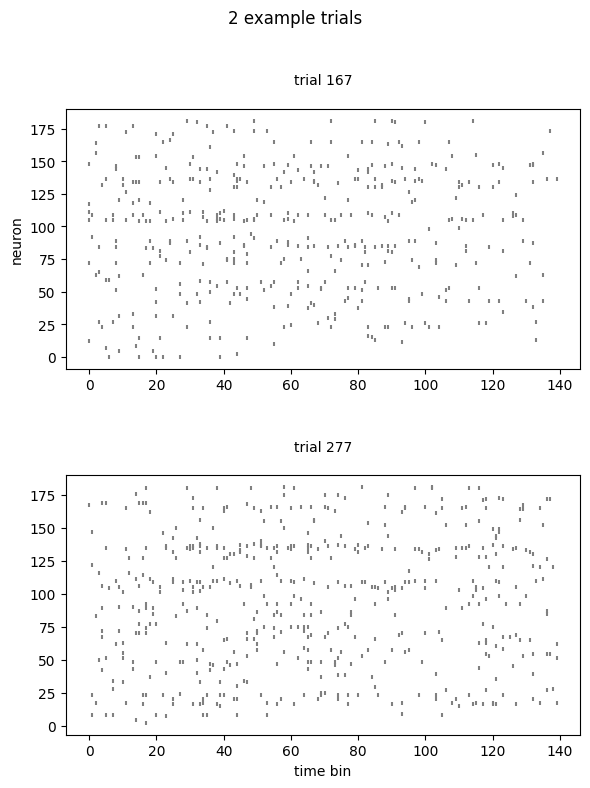

In [36]:
n_ex_trials = 2
trials_inds = np.random.choice(range(0, y_test_obs.shape[0]), size=n_ex_trials, replace=False)

fig, axes = plt.subplots(nrows=n_ex_trials, figsize=(6, 8))
fig.suptitle(f'{n_ex_trials} example trials')

for trial_idx, trial in enumerate(trials_inds):
    for neuron_idx in range(y_test_obs.shape[2]):
        
        axes[trial_idx].set_title(f'\n\ntrial {trial+1}\n', fontsize=10)
        axes[trial_idx].scatter(
            np.where(y_test_obs[trial, :, neuron_idx].cpu() == 1)[0],
            [neuron_idx] * len(np.where(y_test_obs[trial, :, neuron_idx].cpu() == 1)[0]),
            s=10, color='gray', marker='|'
        )
        
axes[n_ex_trials-1].set_xlabel(f'time bin')
axes[0].set_ylabel(f'neuron')

plt.tight_layout()
plt.show()

### Define the structure of the state-space graphical model

The basic elements of any state space model are:<br>
- **the State Equation**, i.e. the dynamics that governs how the latents (state variables) evolve over time.
- and, **the Observations Model**, i.e. the data likelihood, given the latents, that governs how the state variables can generate corresponding observations.

The modules to build up the state space model, to be infered by XFADS, are organized as Python classes, in a way allowing users to change and plug in their own definitions of the classes that structure the elements of the model, i.e. the dynamics function, the likelihood density, the amortization network, etc. The configuration depends on the problem - `dynamics_mod`, `initial_c_pdf`, `likelihood_pdf`, `local_encoder`, and `backward_encoder` can be configured as desired. We include some general classes in `ssm_modules/encoders`, `ssm_modules/likelihoods`, and `ssm_modules/dynamics` that should be sufficient for a wide range of problems.  Below is an example configuration.

In each iteration of the Variational Inference, we need to optimize the parameters of the approximate posterior, which can be quite inefficient, to enable amortized inference for the state-space model, we follow the technique of using a trainable NN, known as an **inference network** or **recognition network**, to predict these parameters from the observed data.

A possible drawback of the traditional inference frameworks is that missing observations obstruct inference. But in a state-space graphical model, the latent state posterior should be accessible for every time point even with missing observations. To enable the amortized inference network to process missing observations in a principled way, we decompose the natural parameter update, of the approximate posterior, into two additive components (explained, and the intuition behind it, more in the next step).

For a detailed building of XFADS, check the Method section of [the paper](https://arxiv.org/abs/2403.01371).

### The Likelihood
XFADS allows non-conjugate prior updates, meaning that the choice of the observation model doesn't have to be in a probability distribution conjugate to the prior dynamics, which was an obstacle to traditional state-apace modeling methods.

Since the likelihood is used to sample observations given the latest representation, it would make better sense to use a Poisson Likelihood when dealing with spiking data (for XFADS it just has to be part of the Exponential family of distribution).

In [153]:
"""likelihood pdf"""
H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
readout_fn = nn.Sequential(H, nn.Linear(cfg.n_latents_read, n_neurons_obs))
readout_fn[-1].bias.data = prob_utils.estimate_poisson_rate_bias(train_dataloader, cfg.bin_sz)
likelihood_pdf = PoissonLikelihood(readout_fn, n_neurons_obs, cfg.bin_sz, device=cfg.device)

### The dynamics model
Now, we have to start from a prior definition of how the latent state evolves over time. This prior belief will be periodically updated during fitting the state-space model.

In [155]:
"""dynamics module"""
Q_diag = 1. * torch.ones(cfg.n_latents, device=cfg.device)
dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=cfg.device)
dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=cfg.device)

In [157]:
"""initial condition"""
m_0 = torch.zeros(cfg.n_latents, device=cfg.device)
Q_0_diag = 1. * torch.ones(cfg.n_latents, device=cfg.device)
initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=cfg.device)


nl_filter = NonlinearFilter(dynamics_mod, initial_condition_pdf, device=cfg.device)

"""sequence vae"""
ssm = LowRankNonlinearStateSpaceModel(dynamics_mod, likelihood_pdf, initial_condition_pdf, backward_encoder,
                                      local_encoder, nl_filter, device=cfg.device)

### The local and the backward encoders

One can intuit that the posterior of the latent state can be considered as a gateway to the latent space. The latent space is always there, regardless of how we can map our data back to. So, if there is a missing observation at a specific point in time, the most reliable way possible to not lose connection with - and alter how we infer the dynamics of the latents - is to use the information encoded in what we observed before. How the optimization function and the inference network of XFADS are designed enables the Filtering distribution to encode, given current pseudo observation, information of future observations.

Accordingly, we decompose the update of the natural parameter of the approximate posterior, i.e. the inference network to learn the parameters of the approximate posterior into **i) a local encoder**, for current observation, and **ii) a backward encoder**, for future observations, i.e.

\begin{matrix}
\large\tilde\lambda_{\phi}(y_{t:T}) = \alpha_{\phi}(y_{t}) + \beta_{\phi}(y_{t+1:T})
\end{matrix}

In [159]:
"""local/backward encoder"""
backward_encoder = BackwardEncoderLRMvn(cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
                                        rank_local=cfg.rank_local, rank_backward=cfg.rank_backward,
                                        device=cfg.device)
local_encoder = LocalEncoderLRMvn(cfg.n_latents, n_neurons_obs, cfg.n_hidden_local, cfg.n_latents,
                                  rank=cfg.rank_local,
                                  device=cfg.device, dropout=cfg.p_local_dropout)

### Train the model

In [ ]:
"""lightning"""
model_ckpt_path = 'ckpts/smoother/acausal/epoch=557_valid_loss=2069.53_r2_valid_enc=0.78_r2_valid_bhv=0.67_valid_bps_enc=0.55.ckpt'
seq_vae = LightningMonkeyReaching.load_from_checkpoint(model_ckpt_path, ssm=ssm, cfg=cfg,
                                                       n_time_bins_enc=cfg.n_bins_enc, n_time_bins_bhv=cfg.n_bins_bhv,
                                                       strict=False)
#seq_vae = LightningMonkeyReaching(ssm, cfg, cfg.n_bins_enc, cfg.n_bins_bhv)

csv_logger = CSVLogger('logs/smoother/acausal/', name=f'sd_{cfg.seed}_r_y_{cfg.rank_local}_r_b_{cfg.rank_backward}', version='smoother_acausal')
ckpt_callback = ModelCheckpoint(save_top_k=3, monitor='r2_valid_enc', mode='max', dirpath='ckpts/smoother/acausal/', save_last=True,
                                filename='{epoch:0}_{valid_loss:0.2f}_{r2_valid_enc:0.2f}_{r2_valid_bhv:0.2f}_{valid_bps_enc:0.2f}')

accumulator = GradientAccumulationScheduler(scheduling={0: cfg.batch_sz//cfg.minibatch_sz,})

trainer = lightning.Trainer(max_epochs=cfg.n_epochs,
                            accelerator=cfg.device,
                            gradient_clip_val=1.0,
                            default_root_dir='lightning/',
                            callbacks=[ckpt_callback],
                            logger=csv_logger,
                            ) 

trainer.fit(model=seq_vae, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)
torch.save(ckpt_callback.best_model_path, 'ckpts/smoother/acausal/best_model_path.pt')
trainer.test(dataloaders=test_dataloader, ckpt_path='last')

### Load the trained model

In [160]:
"""lightning"""
model_ckpt_path = 'ckpts/smoother/acausal/epoch=497_valid_loss=2061.79_r2_valid_enc=0.84_r2_valid_bhv=0.75_valid_bps_enc=0.57.ckpt'
seq_vae = LightningMonkeyReaching.load_from_checkpoint(model_ckpt_path, ssm=ssm, cfg=cfg,
                                                       n_time_bins_enc=cfg.n_bins_enc, n_time_bins_bhv=cfg.n_bins_bhv,
                                                       strict=False)
"""extract trained ssm from lightning module"""
seq_vae.ssm = seq_vae.ssm.to(cfg.device)
seq_vae.ssm.eval()

LowRankNonlinearStateSpaceModel(
  (nl_filter): NonlinearFilter(
    (dynamics_mod): DenseGaussianDynamics(
      (mean_fn): DynamicsGRU(
        (gru_cell): GRUCell(0, 128)
        (h_to_z): Linear(in_features=128, out_features=40, bias=True)
        (z_to_h): Linear(in_features=40, out_features=128, bias=True)
      )
    )
    (initial_c_pdf): DenseGaussianInitialCondition()
  )
  (dynamics_mod): DenseGaussianDynamics(
    (mean_fn): DynamicsGRU(
      (gru_cell): GRUCell(0, 128)
      (h_to_z): Linear(in_features=128, out_features=40, bias=True)
      (z_to_h): Linear(in_features=40, out_features=128, bias=True)
    )
  )
  (local_encoder): LocalEncoderLRMvn(
    (mlp): Sequential(
      (0): Linear(in_features=182, out_features=256, bias=True)
      (1): SiLU()
      (2): Dropout(p=0.4, inplace=False)
      (3): Linear(in_features=256, out_features=640, bias=True)
    )
  )
  (initial_c_pdf): DenseGaussianInitialCondition()
  (likelihood_pdf): PoissonLikelihood(
    (readout_fn): 

In [161]:
if torch.cuda.is_available():
    from torch.cuda import memory_allocated, memory_reserved, memory_stats

    gc.collect()
    torch.cuda.empty_cache()

    if cfg.device == 'cuda':
        print("Active GPU Tensors:\n")
        for i, tensor in enumerate([obj for obj in gc.get_objects() if torch.is_tensor(obj) and obj.is_cuda]):
            print(f"Tensor {i+1}: size {tensor.size()}, dtype {tensor.dtype}, memory {tensor.element_size() * tensor.nelement() / 1e6} MB")

        print(f"\nTotal memory: {torch.cuda.get_device_properties(0).total_memory / 1e9} GB")
        print(f"Allocated memory: {torch.cuda.memory_allocated(0) / 1e9} GB")
        print(f"Reserved memory: {torch.cuda.memory_reserved(0) / 1e9} GB")
        print(f"Cached memory: {torch.cuda.memory_cached(0) / 1e9} GB")
        print(f"Free memory: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved(0)) / 1e9} GB")

### Inferring latent trajectories and generating corresponding observations
Before following the traditional regime of variational inference tools built on the autoencoders framework, i.e. mapping in puts into a latent space, and generating new observations that fall into the input space, we should draw attention to specific criteria that form the scaffolding of XFADS performance and unicity.

### 1. Handeling missing observastions
Typically, setting $y_{t} = 0$ to represent a missing observation, i.e. no update on the prior, would introduce a harmful inductive bias. XFADS overcomes this by introducing the update of the natural parameter of the approximation by the dependence on the pseudo observations.

### 2. Variational Smoothing as Filtering
Drawing inspiration from conjugate Bayesian Inference (where the prior distribution and the likelihood function are chosen such that the posterior distribution belongs to the same family as the prior distribution), the **natural parameters of the posterior** can be expressed as a sum-separable combination of the **natural parameters of the prior** and a **data dependent term**.
\begin{matrix}
\large\lambda_{\phi}(z_{t-1}, y_{t:T}) = \lambda_{\theta}(z_{t-1}) + \tilde\lambda_{\theta}(y_{t:T})
\end{matrix}

**This separation allows the approximate posterior to hold even when there are missing observations** (e.g. a circuit glitch, lost signal, etc). In such case, the term $\lambda_{\theta}(z_{t-1})$ vanishes, and $\tilde\lambda_{\theta}(y_{t:T})$ can be thought of as a data-dependent update of a prior over, what we call, **a pseudo observation $\tilde{y}_{t}$**.

$\lambda_{\phi}(z_{t-1}, y_{t:T})$, the variational smoothing posterior, depends on all past observations (encoded in $z_{t-1}$), and the current and future observations ($y_{t:T}$). But since a single pseudo observation $\tilde{y}_{t}$ encodes information about $y_{t:T}$, the filtering distribution (when the dependence is on the past and current observations) given the pseudo-observations should be able to approximate the smoothing distribution (when the dependence is on past, current, and future observations) for the raw data, i.e.

\begin{matrix}
\large{p}(z_{t}|\tilde{y}_{1:t}) = p(z_{t}|y_{t:T})
\end{matrix}

Latents sampled from the inferred smoothing distribution and the inferred filtering distribution are visualized in the next steps.

### 3. Predicting the latent trajectory given the latent state at point t as an initial condition
Another advantage of XFADS that gives it a high potential for real-time BCIs and on-line inference and decoding is its ability to take any latent state $z$ at a point in time $t$ within the preparatory period before executing the movement and exploit it as an initial condition to predict the remaining of the latent trajectory for the rest of the trial. 

In [51]:
"""inference"""
z_s_train = []
z_f_train = []
z_p_train = []

rates_train_s = []
rates_train_f = []
rates_train_p = []

z_s_valid = []
z_f_valid = []
z_p_valid = []

rates_valid_s = []
rates_valid_f = []
rates_valid_p = []

z_s_test = []
z_f_test = []
z_p_test = []

rates_test_s = []
rates_test_f = []
rates_test_p = []

stats_s_train = []
stats_f_train = []
stats_s_valid = []
stats_f_valid = []
stats_s_test = []
stats_f_test = []

with torch.no_grad():
    m_0 = seq_vae.ssm.nl_filter.initial_c_pdf.m_0
    Q_0 = Fn.softplus(seq_vae.ssm.nl_filter.initial_c_pdf.log_Q_0)
    #m_0 = seq_vae.ssm.dynamics_mod.initial_c_pdf.m_0
    #Q_0 = Fn.softplus(seq_vae.ssm.dynamics_mod.initial_c_pdf.log_Q_0)

    z_ic = m_0 + Q_0.sqrt() * torch.randn([n_test_trials, n_neurons_obs] + [cfg.n_latents], device=cfg.device)
    #z_ic_p = seq_vae.ssm.predict_forward(z_ic[:, :, cfg.n_bins_bhv], cfg.n_bins - cfg.n_bins_bhv)

    for batch_idx, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="train dataloader"):
        loss, z_s, stats_s = seq_vae.ssm(batch[0].to(cfg.device), cfg.n_samples)
        z_f, stats_f = seq_vae.ssm.fast_filter_1_to_T(batch[0].to(cfg.device), cfg.n_samples)
        z_p = seq_vae.ssm.predict_forward(z_f[:, :, cfg.n_bins_bhv], cfg.n_bins - cfg.n_bins_bhv)
        z_p = torch.cat([z_f[:, :, :cfg.n_bins_bhv], z_p], dim=2)
        
        rates_s = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_s)).mean(dim=0).to('cpu')
        rates_f = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_f)).mean(dim=0).to('cpu')
        rates_p = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_p)).mean(dim=0).to('cpu')
        
        z_s_train.append(z_s.to('cpu'))
        z_f_train.append(z_f.to('cpu'))
        z_p_train.append(z_p.to('cpu'))
        
        rates_train_s.append(rates_s)
        rates_train_f.append(rates_f)
        rates_train_p.append(rates_p)
        
        stats_s_train.append(stats_s)
        stats_f_train.append(stats_f)

    for batch_idx, batch in tqdm(enumerate(valid_dataloader), total=len(test_dataloader), desc="valid dataloader"):
        loss, z_s, stats_s = seq_vae.ssm(batch[0].to(cfg.device), cfg.n_samples)
        z_f, stats_f = seq_vae.ssm.fast_filter_1_to_T(batch[0].to(cfg.device), cfg.n_samples)
        z_p = seq_vae.ssm.predict_forward(z_f[:, :, cfg.n_bins_bhv], cfg.n_bins - cfg.n_bins_bhv)
        z_p = torch.cat([z_f[:, :, :cfg.n_bins_bhv], z_p], dim=2)
        
        rates_s = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_s)).mean(dim=0).to('cpu')
        rates_f = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_f)).mean(dim=0).to('cpu')
        rates_p = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_p)).mean(dim=0).to('cpu')
        
        z_s_valid.append(z_s.to('cpu'))
        z_f_valid.append(z_f.to('cpu'))
        z_p_valid.append(z_p.to('cpu'))
        
        rates_valid_s.append(rates_s)
        rates_valid_f.append(rates_f)
        rates_valid_p.append(rates_p)
        
        stats_s_valid.append(stats_s)
        stats_f_valid.append(stats_f)
        
    for batch_idx, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc="test dataloader"):
        loss, z_s, stats_s = seq_vae.ssm(batch[0].to(cfg.device), cfg.n_samples)
        z_f, stats_f = seq_vae.ssm.fast_filter_1_to_T(batch[0].to(cfg.device), cfg.n_samples)
        z_p = seq_vae.ssm.predict_forward(z_f[:, :, cfg.n_bins_bhv], cfg.n_bins - cfg.n_bins_bhv)
        z_p = torch.cat([z_f[:, :, :cfg.n_bins_bhv], z_p], dim=2)
        
        rates_s = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_s)).mean(dim=0).to('cpu')
        rates_f = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_f)).mean(dim=0).to('cpu')
        rates_p = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_p)).mean(dim=0).to('cpu')
        
        z_s_test.append(z_s.to('cpu'))
        z_f_test.append(z_f.to('cpu'))
        z_p_test.append(z_p.to('cpu'))
        
        rates_test_s.append(rates_s)
        rates_test_f.append(rates_f)
        rates_test_p.append(rates_p)
        
        stats_s_test.append(stats_s)
        stats_f_test.append(stats_f)

test dataloader: 100%|██████████| 9/9 [00:28<00:00,  3.18s/it]


In [54]:
z_s_train = torch.cat(z_s_train, dim=1).cpu()
z_f_train = torch.cat(z_f_train, dim=1).cpu()
z_p_train = torch.cat(z_p_train, dim=1).cpu()

rates_train_s = torch.cat(rates_train_s, dim=0).cpu()
rates_train_f = torch.cat(rates_train_f, dim=0).cpu()
rates_train_p = torch.cat(rates_train_p, dim=0).cpu()

z_s_valid = torch.cat(z_s_valid, dim=1).cpu()
z_f_valid = torch.cat(z_f_valid, dim=1).cpu()
z_p_valid = torch.cat(z_p_valid, dim=1).cpu()

rates_valid_s = torch.cat(rates_valid_s, dim=0).cpu()
rates_valid_f = torch.cat(rates_valid_f, dim=0).cpu()
rates_valid_p = torch.cat(rates_valid_p, dim=0).cpu()

z_s_test = torch.cat(z_s_test, dim=1).cpu()
z_f_test = torch.cat(z_f_test, dim=1).cpu()
z_p_test = torch.cat(z_p_test, dim=1).cpu()

rates_test_s = torch.cat(rates_test_s, dim=0).cpu()
rates_test_f = torch.cat(rates_test_f, dim=0).cpu()
rates_test_p = torch.cat(rates_test_p, dim=0).cpu()

### Visualize the covariance matrix
We know how neat and nice a diagonal covariance matrix would be. But these covariance structures don't have much freedom to explore the space of relationships between the state variables but, they are easier to compute. There is this trade-off between performance and computational efficiency. This gets more complex compuationally for largte scale models and dataset.</br>
XFADS is capable of capturing the dense covariance structure - crucial for more accurate dynamic updates of the latent states - of large-scale state-space models.

In [174]:
ks = ['kl', 'm_s', 'm_f', 'm_p', 'Psi_f', 'Psi_p']
stats_f = {k: torch.cat(tuple([stats_s_valid[b]['m_f'] for b in range(len(valid_dataloader))]), dim=0) for k in ks}
stats_p = {k: torch.cat(tuple([stats_s_valid[b]['m_f'] for b in range(len(valid_dataloader))]), dim=0) for k in ks}

In [175]:
stats_f.keys()

dict_keys(['kl', 'm_s', 'm_f', 'm_p', 'Psi_f', 'Psi_p'])

In [176]:
stats_f['Psi_f'].shape

torch.Size([286, 140, 40])

In [177]:
'''
spikes per time bin.

To get the number of spikes within each time bin, we should do the poisson sampling from the firing rate as
the number of spikes per time bin.
'''

spikes_train_s = torch.poisson(cfg.bin_sz * rates_train_s).cpu()
spikes_train_f = torch.poisson(cfg.bin_sz * rates_train_f).cpu()
spikes_train_p = torch.poisson(cfg.bin_sz * rates_train_p).cpu()

spikes_test_s = torch.poisson(cfg.bin_sz * rates_test_s).cpu()
spikes_test_f = torch.poisson(cfg.bin_sz * rates_test_f).cpu()
spikes_test_p = torch.poisson(cfg.bin_sz * rates_test_p).cpu()

spikes_valid_s = torch.poisson(cfg.bin_sz * rates_valid_s).cpu()
spikes_valid_f = torch.poisson(cfg.bin_sz * rates_valid_f).cpu()
spikes_valid_p = torch.poisson(cfg.bin_sz * rates_valid_p).cpu()

In [194]:
"""colors"""
blues = cm.get_cmap("winter", z_s_test.shape[0])
reds = cm.get_cmap("summer", z_s_test.shape[0])
springs = cm.get_cmap("spring", z_s_test.shape[0])

color_map_list = [blues, reds, springs]
event_c = ['purple', 'coral', 'navy']
colors = ['coral', 'navy', 'teal']

n_ex_trials = 4
trial_indcs = np.random.choice(range(0, y_test_obs.shape[0]), size=n_ex_trials, replace=False)


def plot_z_samples(fig, axs, latents, bhv_bins, trial_indcs, cfg, color_map_list, regime=None):
    
    samples = latents[:, trial_indcs, ..., :3]
    n_samples, n_trials, n_bins, n_latents = samples.shape
    
    fig.subplots_adjust(hspace=0)
    
    if regime == 'prediction':
        [axs[i].axvline(cfg.n_bins_bhv * cfg.bin_sz_ms, linestyle='--', color='red') for i in range(n_trials)]
    for bi in range(bhv_bins.shape[1]):
        [axs[i].axvline(bhv_bins[trial_indcs[i], bi] * cfg.bin_sz_ms, linestyle='--', color=event_c[bi]) for i in range(n_trials)]
    
    [axs[i].axis('off') for i in range(n_trials-1)]
    axs[-1].yaxis.set_visible(False)
    axs[-1].spines['left'].set_visible(False)
    axs[-1].spines['right'].set_visible(False)
    axs[-1].spines['top'].set_visible(False)
    
    axs[-1].set_xlabel('time (ms)', fontsize=9)
    
    # Plot the 25 samples of each latent
    [axs[i].plot(np.arange(n_bins) * cfg.bin_sz_ms, samples[j, i, :, n], color=color_map_list[n](j), linewidth=0.5, alpha=0.3)
     for i in range(n_trials) for j in range(samples.shape[0]) for n in range(n_latents)]
    
    # On top of the 25 samples, plot the mean.
    [axs[i].plot(np.arange(n_bins) * cfg.bin_sz_ms, samples[:, i, :, n].mean(dim=0), color=colors[n], linewidth=1.5, alpha=0.8)
     for i in range(n_trials) for n in range(n_latents)]
    
    [axs[i].set_title(f'trial {trial_indcs[i]+1}', fontsize=7) for i in range(n_trials)]
    [axs[i].set_xlim(0, n_bins * cfg.bin_sz_ms,) for i in range(n_trials)]


def mark_events(cfg, bhv_bins, trial_indc, regime=None):
    y_min, _ = plt.ylim()
    
    if regime == 'prediction':
        plt.annotate('pred\nstarts', xy=(cfg.n_bins_bhv * cfg.bin_sz_ms, y_min), xytext=(cfg.n_bins_bhv * cfg.bin_sz_ms - 0.25 * cfg.n_bins_bhv * cfg.bin_sz_ms, y_min + 0.9 * y_min),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=8, ha='center'
                )
    for bi in range(bhv_bins.shape[1]):
        e = bhv_bins[trial_indcs[-1], bi]
        if torch.isnan(e):
            continue
        bhv = events_str[bi]
        plt.annotate(bhv, xy=(e * cfg.bin_sz_ms, y_min), xytext=(e * cfg.bin_sz_ms + 0.25 * cfg.n_bins_bhv * cfg.bin_sz_ms , y_min + 0.9 * y_min),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     fontsize=8, ha='center'
                    )

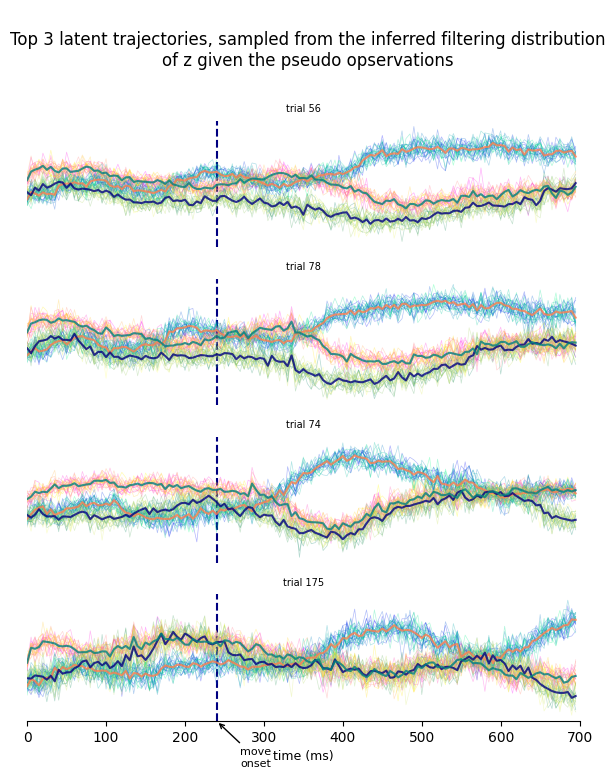

In [195]:
"""filtered"""
fig, axs = plt.subplots(len(trial_indcs), 1, figsize=(6, 8))
plot_z_samples(fig, axs, z_f_test.cpu(), b_test, trial_indcs, cfg, color_map_list)
mark_events(cfg, b_test, trial_indcs)
fig.suptitle(f'\nTop 3 latent trajectories, sampled from the inferred filtering distribution\nof z given the pseudo opservations\n')
fig.tight_layout()
plt.savefig("output_figs/z_f_trajectory.png")
plt.show()

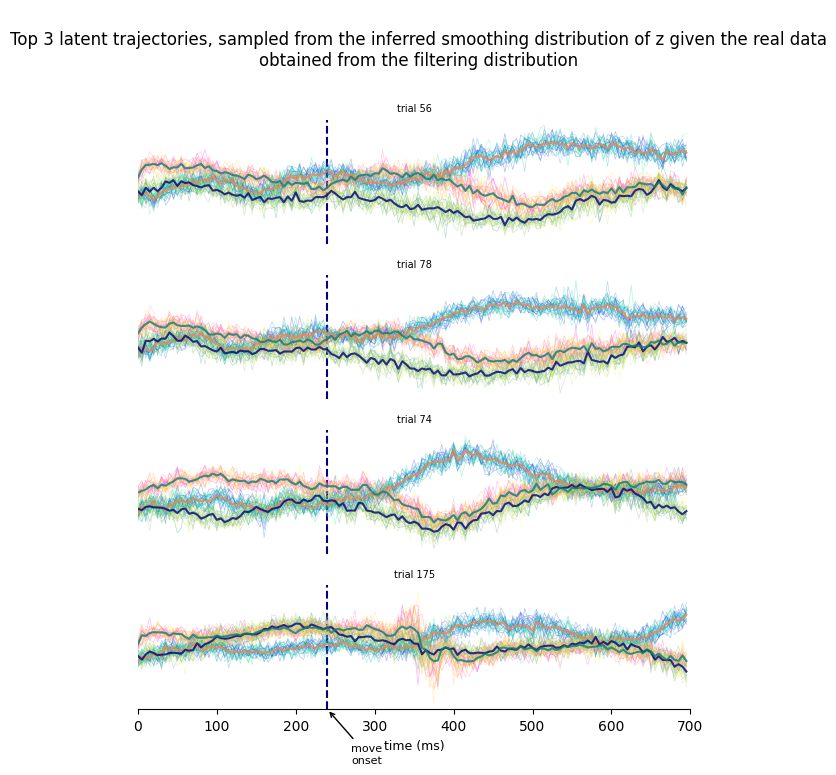

In [196]:
"""smoothed"""
fig, axs = plt.subplots(len(trial_indcs), 1, figsize=(6, 8))
plot_z_samples(fig, axs, z_s_test.cpu(), b_test, trial_indcs, cfg, color_map_list)
mark_events(cfg, b_test, trial_indcs)
fig.suptitle(f'\nTop 3 latent trajectories, sampled from the inferred smoothing distribution of z given the real data\nobtained from the filtering distribution\n')
fig.tight_layout()
plt.savefig("output_figs/z_s_trajectory.png")
plt.show()

### Predicting the latent trajectories given the latent state at point t as an initial condition
A common techniqye to validate a dynamical system is by its ability to forcast the dynamics given minimal information just at the begining of the trial.  XFADS is able to learn a dynamical system capable of forecasting population spiking and behavioral correlates from a small portion of single trials.

This predective cababiliyies of the filtering posterior infered by XFADS give it a high potential for real-time application and on-line inference and decoding is its ability to take any latent state $z$ at a point in time $t$ within the preparatory period before executing the movement and exploit it as an initial condition to predict the remaining of the latent trajectory for the rest of the trial. 

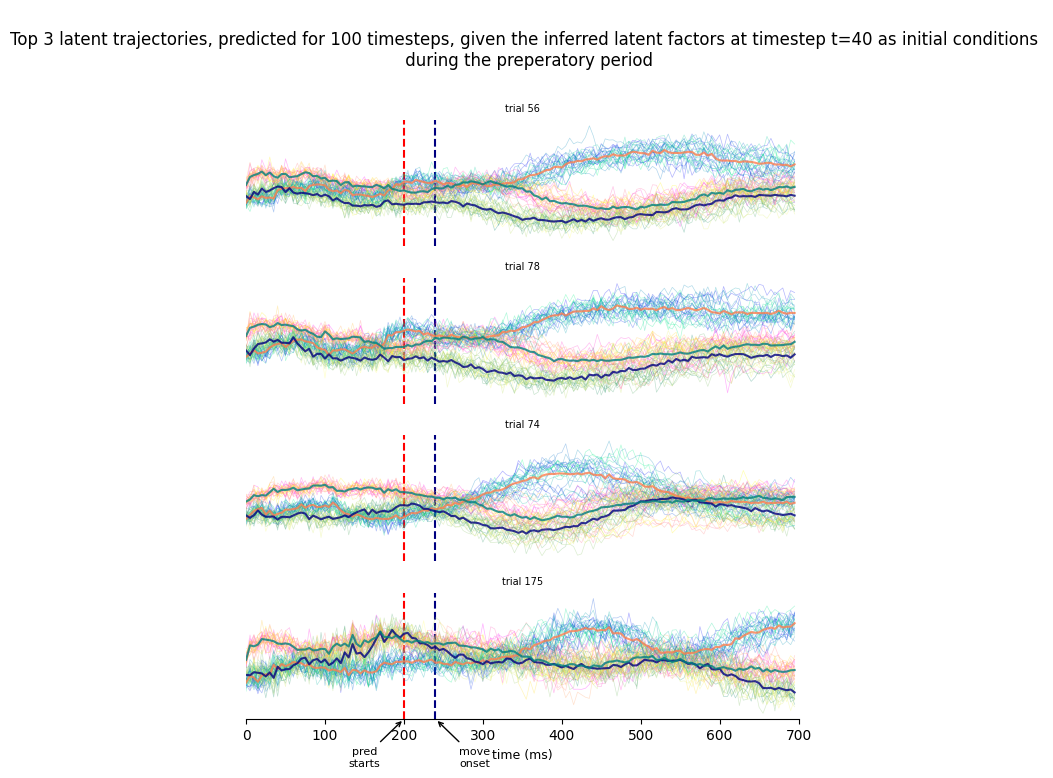

In [198]:
"""predicted"""
fig, axs = plt.subplots(len(trial_indcs), 1, figsize=(6, 8))
plot_z_samples(fig, axs, z_p_test.cpu(), b_test, trial_indcs, cfg, color_map_list, regime='prediction')
mark_events(cfg, b_test, trial_indcs, regime='prediction')
fig.suptitle(f'\nTop 3 latent trajectories, predicted for {cfg.n_bins - cfg.n_bins_bhv} timesteps, given the inferred latent factors at timestep t={cfg.n_bins_bhv} as initial conditions \n during the preperatory period\n')
fig.tight_layout()
plt.savefig("output_figs/z_p_trajectory.png")
plt.show()

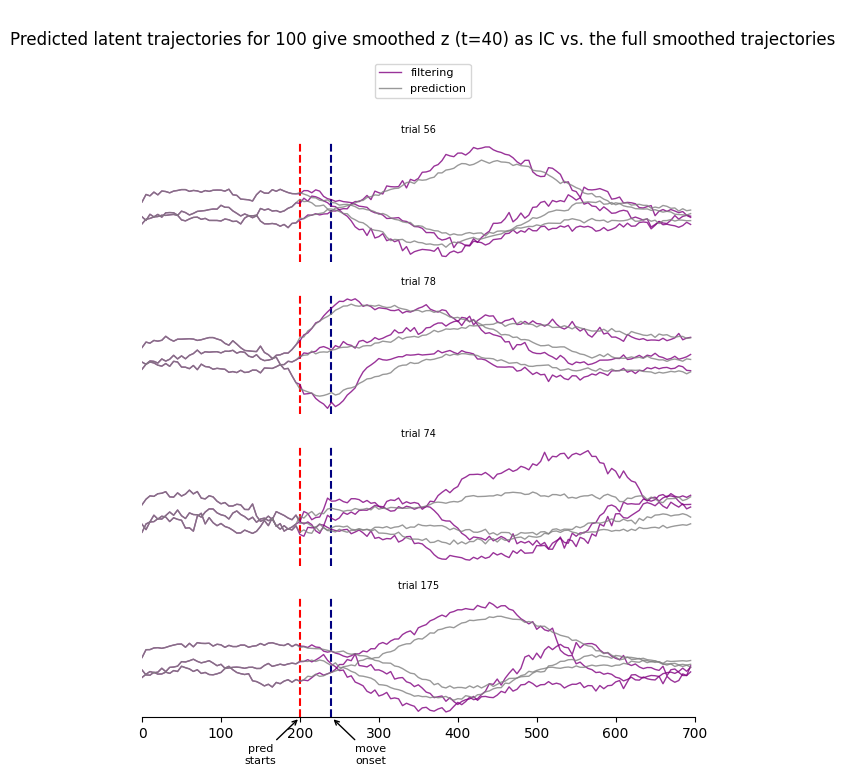

In [199]:
#n_ex_trials = 4
#trial_indcs = np.random.choice(range(0, y_test_obs.shape[0]), size=n_ex_trials, replace=False)

def plot_f_vs_p(fig, axs, z_f_z_p, bhv_bins, trial_indcs, cfg, colors=None, regimes=None):
    
    samples = z_f_z_p[0][:, trial_indcs, ..., :3]
    n_samples, n_trials, n_bins, n_latents = samples.shape

    fig.subplots_adjust(hspace=0)
    
    [axs[i].axvline(cfg.n_bins_bhv  * cfg.bin_sz_ms, linestyle='--', color='red') for i in range(n_trials)]
    for bi in range(bhv_bins.shape[1]):
        [axs[i].axvline(bhv_bins[trial_indcs[i], bi] * cfg.bin_sz_ms, linestyle='--', color=event_c[bi]) for i in range(n_trials)]
    
    [axs[i].axis('off') for i in range(n_trials-1)]
    axs[-1].yaxis.set_visible(False)
    axs[-1].spines['left'].set_visible(False)
    axs[-1].spines['right'].set_visible(False)
    axs[-1].spines['top'].set_visible(False)
    
    for ir, regime in enumerate(regimes):
        [axs[i].plot(np.arange(n_bins) * cfg.bin_sz_ms, z_f_z_p[ir][:, i, :, n].mean(dim=0), color=colors[ir], linewidth=1.0, alpha=0.8, label=regime if i==0 and n==0 else '')
         for i in range(n_trials) for n in range(n_latents)]
    
    [axs[i].set_title(f'trial {trial_indcs[i]+1}', fontsize=7) for i in range(n_trials)]
    [axs[i].set_xlim(0, n_bins * cfg.bin_sz_ms) for i in range(n_trials)]


fig, axs = plt.subplots(len(trial_indcs), 1, figsize=(6, 8))
plot_f_vs_p(fig, axs, [z_f_test, z_p_test], b_test, trial_indcs, cfg, colors=['purple', 'gray'], regimes=['filtering', 'prediction'])
mark_events(cfg, b_test, trial_indcs, regime='prediction')
fig.suptitle(f'\nPredicted latent trajectories for {cfg.n_bins - cfg.n_bins_bhv} give smoothed z (t={cfg.n_bins_bhv}) as IC vs. the full smoothed trajectories\n\n\n')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=1, fontsize=8)
fig.tight_layout()
plt.savefig("output_figs/f_vs_p.png")

### Low-rank covariance structre

### Reconstructed trials vs observations

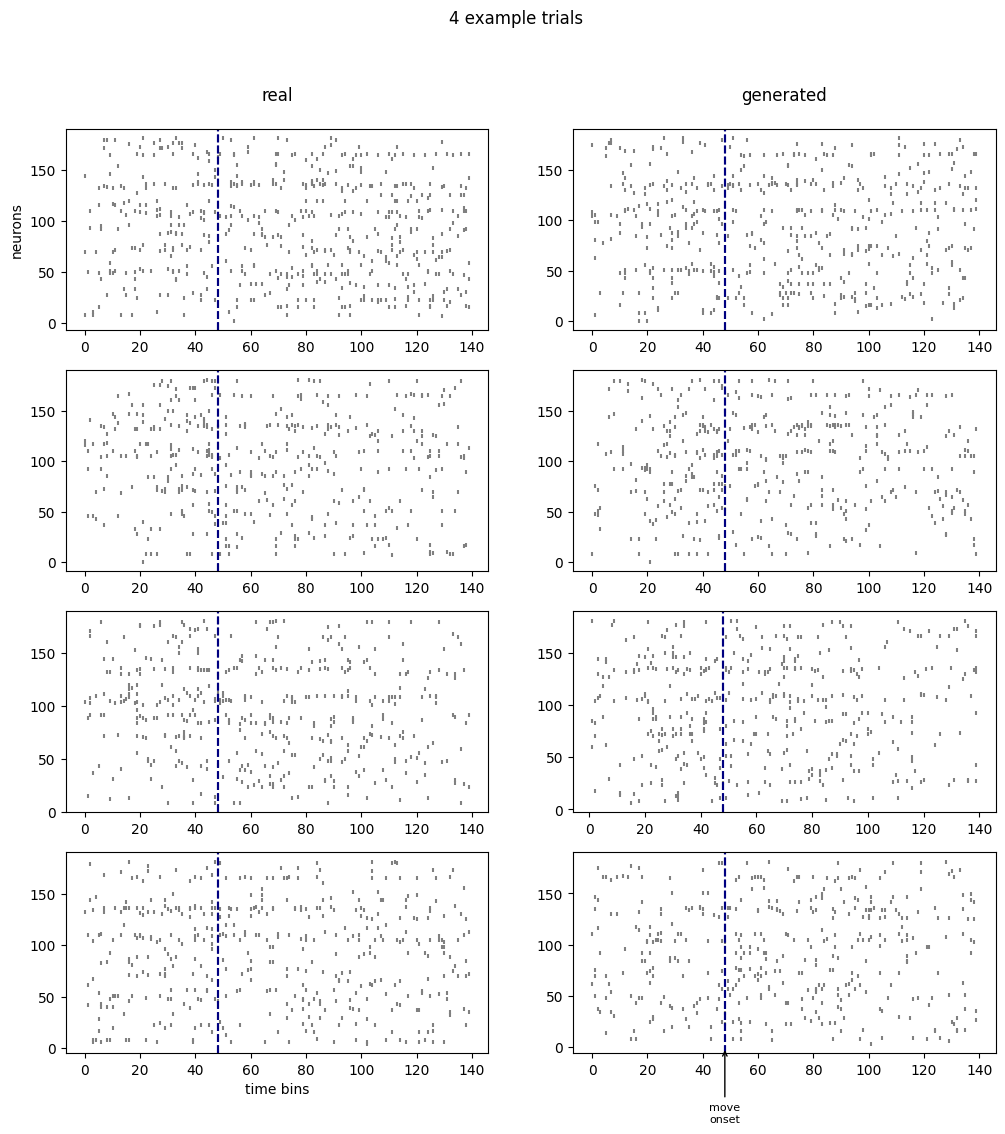

In [66]:
n_ex_trials = 4
trial_indcs = np.random.choice(range(0, spikes_valid_s.shape[0]), size=n_ex_trials, replace=False)

fig, axes = plt.subplots(ncols=2, nrows=n_ex_trials, figsize=(12, 12))
fig.suptitle(f'{n_ex_trials} example trials')

for trial_idx, trial in enumerate(trial_indcs):
    for neuron_idx in range(spikes_valid_s.shape[2]):
        
        axes[trial_idx, 0].scatter(
            np.where(y_valid_obs[trial, :, neuron_idx] == 1)[0],
            [neuron_idx] * len(np.where(y_valid_obs[trial, :, neuron_idx] == 1)[0]),
            s=10, color='gray', marker='|'
        )
        axes[trial_idx, 1].scatter(
            np.where(spikes_valid_s[trial, :, neuron_idx] == 1)[0],
            [neuron_idx] * len(np.where(spikes_valid_s[trial, :, neuron_idx] == 1)[0]),
            s=10, color='gray', marker='|'
        )
        
[ax.axvline(b_test[trial_indcs[-1], 2], linestyle='--', color='navy') for ax in axes.flat]
[ax.axvline(b_test[trial_indcs[-1], 2], linestyle='--', color='navy') for ax in axes.flat]

if not torch.isnan(b_test[trial_indcs[-1], 0]):
    plt.annotate('target on', xy=(b_test[trial_indcs[-1], 0], 0), xytext=(b_test[trial_indcs[-1], 0], -0.4*n_neurons_obs),
         arrowprops=dict(facecolor='black', arrowstyle='->'),
         fontsize=8, ha='center')

if not torch.isnan(b_test[trial_indcs[-1], 1]):
    plt.annotate('go cue', xy=(b_test[trial_indcs[-1], 1], 0), xytext=(b_test[trial_indcs[-1], 1], -0.4*n_neurons_obs),
         arrowprops=dict(facecolor='black', arrowstyle='->'),
         fontsize=8, ha='center')

plt.annotate('move\nonset', xy=(b_test[trial_indcs[-1], 2], 0), xytext=(b_test[trial_indcs[-1], 2], -0.4*n_neurons_obs),
     arrowprops=dict(facecolor='black', arrowstyle='->'),
     fontsize=8, ha='center')
        
axes[0, 0].set_title('real\n')
axes[0, 1].set_title('generated\n')
        
axes[len(trial_indcs)-1, 0].set_xlabel(f'time bins')
axes[0, 0].set_ylabel(f'neurons')

plt.savefig("output_figs/reconstructed_vs_real.png")

plt.show()

### Neurons spike count

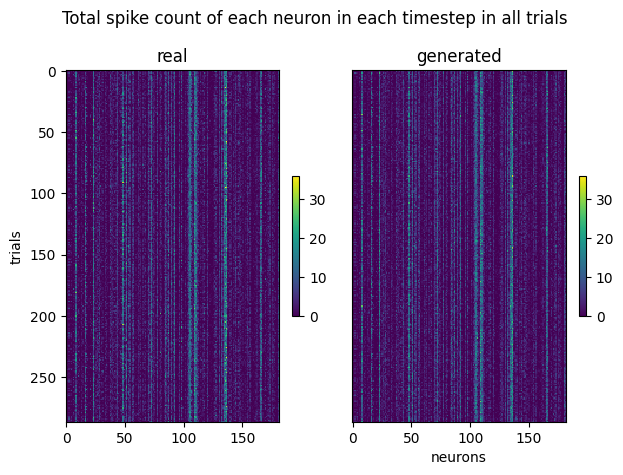

In [68]:
data_spike_count = torch.sum(y_test_obs, axis=1)
model_spike_count = torch.sum(spikes_test_s, axis=1)

fig, axs = plt.subplots(ncols=2)
fig.suptitle('Total spike count of each neuron in each timestep in all trials')

with torch.no_grad():
    
    axs[0].set_title('real')
    dsc = axs[0].imshow(data_spike_count, interpolation='none', aspect='auto')
    axs[1].set_title('generated')
    msc = axs[1].imshow(model_spike_count, interpolation='none', aspect='auto')

    vmin, _ = min(torch.min(data_spike_count.flatten(), dim=0), torch.min(model_spike_count.flatten(), dim=0))
    vmax, _ = max(torch.max(data_spike_count.flatten(), dim=0), torch.max(model_spike_count.flatten(), dim=0))

    fig.colorbar(dsc, ax=axs[0], shrink=0.4).mappable.set_clim(vmin=vmin, vmax=vmax)
    fig.colorbar(msc, ax=axs[1], shrink=0.4).mappable.set_clim(vmin=vmin, vmax=vmax)
                
axs[1].set_xlabel('neurons')
axs[0].set_ylabel('trials')

axs[1].set_yticks([])

plt.tight_layout()

plt.savefig("output_figs/spike_count.png")
plt.show()

### Trial-averaged single neuron activity

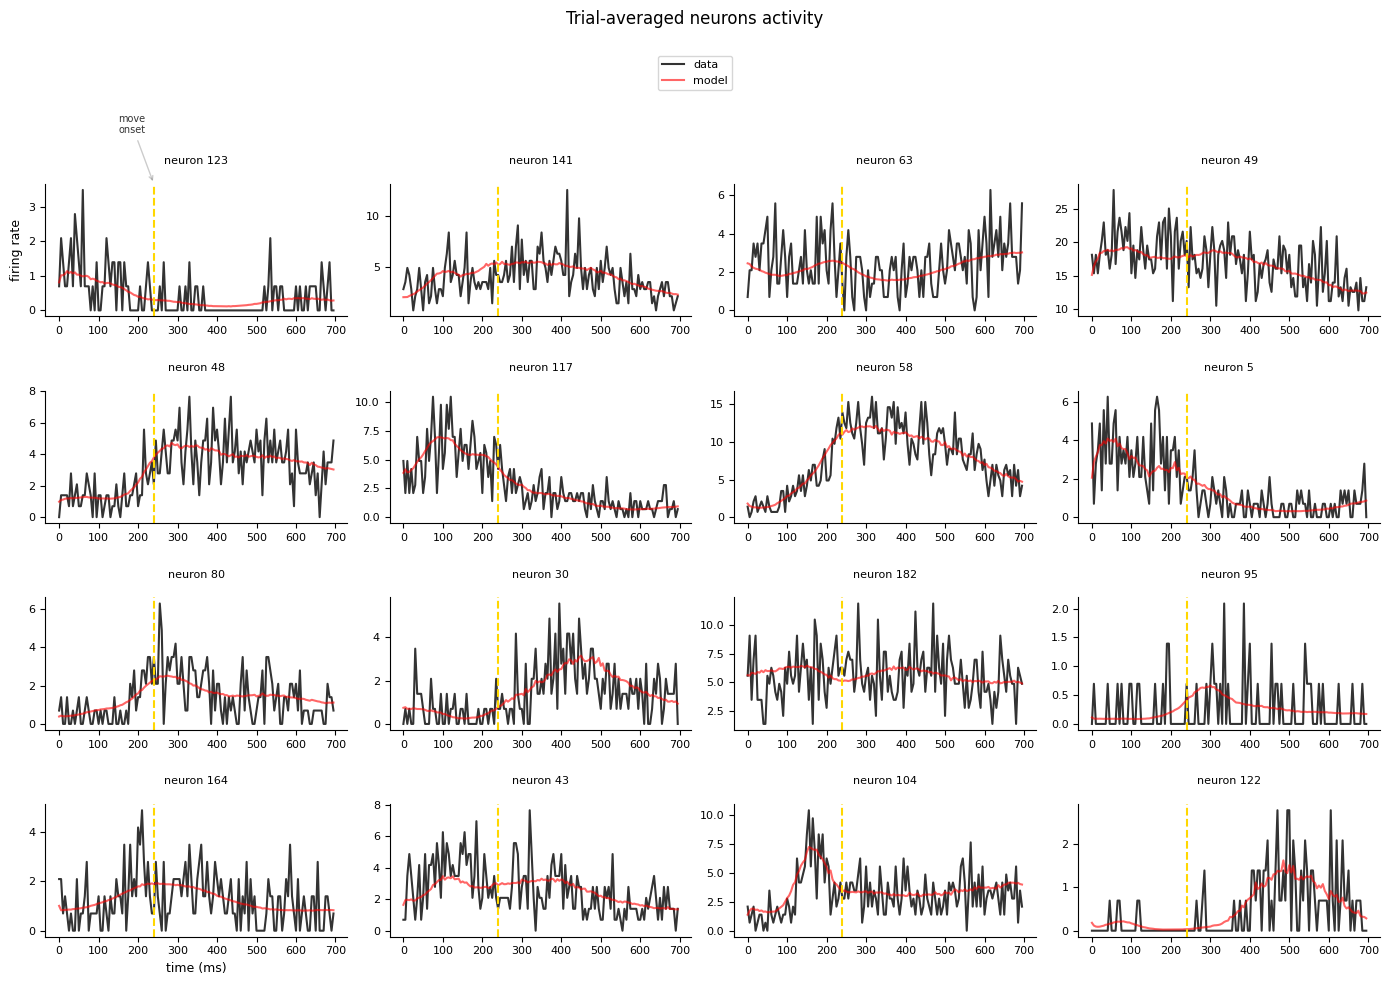

In [77]:
def mark_events_on_psth(ax, cfg, bhv_bins):
    _, y_upper_limit = ax.get_ylim()
    
    for bi in range(bhv_bins.shape[1]):
        bhv_bin = bhv_bins[:, bi].mean(dim=0)
        if torch.isnan(bhv_bin):
            continue
        ev = events_str[bi]

        ax.annotate(f"{ev}",
                    xy=(bhv_bin * cfg.bin_sz_ms, y_upper_limit),
                    xytext=(bhv_bin * cfg.bin_sz_ms - (cfg.n_bins * 0.4), (y_upper_limit * 1.4)),
                    arrowprops=dict(facecolor='black', alpha=0.2, arrowstyle='->'),
                    fontsize=7, alpha=0.8, ha='center')
        

def plot_avg_activity(y_data, r_model, n_neurons_to_plot=16):
    neuron_indcs = np.random.choice(range(0, y_data.shape[2]), size=n_neurons_to_plot, replace=False)
    
    fig, axes = plt.subplots(int(np.sqrt(n_neurons_to_plot)), int(np.sqrt(n_neurons_to_plot)), figsize=(14, 10))
    fig.suptitle(f'Trial-averaged neurons activity\n\n\n')

    for ax, neuron in zip(axes.flat, neuron_indcs):

        fr_data = torch.tensor(
            # Here we divide by the bin size to get the number of spikes per second, not per bin.
            torch.mean(y_data[:, :, neuron], axis=0) / cfg.bin_sz,
        )

        fr_model= torch.tensor(
            # Average over trials.
            torch.mean(r_model[:, :, neuron], axis=0),
        )

        ax.plot(np.arange(n_bins) * cfg.bin_sz_ms, fr_data, color= 'black', alpha=0.8, label='data' if neuron == neuron_indcs[-1] else '')
        ax.plot(np.arange(n_bins) * cfg.bin_sz_ms, fr_model, color= 'red', alpha=0.6, label='model' if neuron == neuron_indcs[-1] else '')

        #ax.axvline(x=b_test[:, 0].mean(dim=0) * cfg.bin_sz_ms, color='coral', linestyle='--')
        #ax.axvline(x=b_test[:, 1].mean(dim=0) * cfg.bin_sz_ms, color='navy', linestyle='--')
        ax.axvline(x=b_test[:, 2].mean(dim=0) * cfg.bin_sz_ms, color='gold', linestyle='--')

        ax.set_title(f'\nneuron {neuron+1}\n', fontsize=8)
        ax.set_xlabel('time (ms)' if neuron == neuron_indcs[-int(np.sqrt(n_neurons_to_plot))] else '', fontsize=9)
        ax.set_ylabel('firing rate' if neuron == neuron_indcs[0] else '', fontsize=9)
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

        if neuron == neuron_indcs[0]:
            mark_events_on_psth(ax, cfg, b_test)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=1, fontsize=8)
    fig.tight_layout()

    plt.savefig("output_figs/trial_averaged_activity.png")
    plt.show()
    
plot_avg_activity(y_test_obs, rates_test_s)

### Movement preparation and movement executation time
Check this out, it's cool, if you are using data from a motor task with a go cue, therefor, also a time point for initiating the movement, and, if you are lucky, a time point for terminating the movement.

This could be used to predict the reaction time.

In [79]:
def get_move_time(bhv_bins):
    prep_t = bhv_bins[:, 1] - bhv_bins[:, 0]
    move_t = bhv_bins[:, 2] - bhv_bins[:, 1]
    
    return prep_t, move_t

In [80]:
### TODO: Add the code that Matt wrote for predecting reaction time for the analysis ###

### Velocity decoder

In [82]:
vel_train = l_train
vel_valid = l_valid
vel_test = l_test

vel = torch.concat([vel_train, vel_valid, vel_test], dim=0)

In [83]:
data_spikes = torch.concat([y_train_obs, y_valid_obs, y_test_obs], dim=0)
model_spikes = torch.concat([spikes_train_s, spikes_valid_s, spikes_test_s], dim=0)

data_rates = data_spikes / cfg.bin_sz
model_rates = torch.concat([rates_train_s, rates_valid_s, rates_test_s], dim=0)

In [84]:
'''
Note that the decoder is trained on the rates generated by XFADS from the latents inferred from the training data.
But tested on the rates generated from the latents inferred from the validation and the testing data.
'''

clf = Ridge(alpha=0.01)
# fit to training data
clf.fit(rates_train_s.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    
with torch.no_grad():
    r2 = clf.score(rates_train_s.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    
    r2_train = clf.score(rates_train_s.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    r2_valid = clf.score(rates_valid_s.reshape(-1, n_neurons_obs), vel_valid.reshape(-1, 2))
    r2_test = clf.score(rates_test_s.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    
    r2_filter = clf.score(rates_test_f.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    r2_k_step = []
    
    # transform train data
    r2_train_s = clf.score(rates_train_s.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    r2_train_f = clf.score(rates_train_f.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    r2_train_p = clf.score(rates_train_p.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    vel_hat_train_s = clf.predict(rates_train_s.reshape(-1, n_neurons_obs)).reshape(list(y_train_obs.shape)[:-1] + [vel_train.shape[-1]])
    vel_hat_train_f = clf.predict(rates_train_f.reshape(-1, n_neurons_obs)).reshape(list(y_train_obs.shape)[:-1] + [vel_train.shape[-1]])
    vel_hat_train_p = clf.predict(rates_train_p.reshape(-1, n_neurons_obs)).reshape(list(y_train_obs.shape)[:-1] + [vel_train.shape[-1]])
    
    # transform valid data
    r2_valid_s = clf.score(rates_valid_s.reshape(-1, n_neurons_obs), vel_valid.reshape(-1, 2))
    r2_valid_f = clf.score(rates_valid_f.reshape(-1, n_neurons_obs), vel_valid.reshape(-1, 2))
    r2_valid_p = clf.score(rates_valid_p.reshape(-1, n_neurons_obs), vel_valid.reshape(-1, 2))
    vel_hat_valid_s = clf.predict(rates_valid_s.reshape(-1, n_neurons_obs)).reshape(list(y_valid_obs.shape)[:-1] + [vel_valid.shape[-1]])
    vel_hat_valid_f = clf.predict(rates_valid_f.reshape(-1, n_neurons_obs)).reshape(list(y_valid_obs.shape)[:-1] + [vel_valid.shape[-1]])
    vel_hat_valid_p = clf.predict(rates_valid_p.reshape(-1, n_neurons_obs)).reshape(list(y_valid_obs.shape)[:-1] + [vel_valid.shape[-1]])
    
    # transform test data
    r2_test_s = clf.score(rates_test_s.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    r2_test_f = clf.score(rates_test_f.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    r2_test_p = clf.score(rates_test_p.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    vel_hat_test_s = clf.predict(rates_test_s.reshape(-1, n_neurons_obs)).reshape(list(y_test_obs.shape)[:-1] + [vel_test.shape[-1]])
    vel_hat_test_f = clf.predict(rates_test_f.reshape(-1, n_neurons_obs)).reshape(list(y_test_obs.shape)[:-1] + [vel_test.shape[-1]])
    vel_hat_test_p = clf.predict(rates_test_p.reshape(-1, n_neurons_obs)).reshape(list(y_test_obs.shape)[:-1] + [vel_test.shape[-1]])
    
    for k in range(n_bins - cfg.n_bins_bhv):
        z_prd_test = utils.propagate_latent_k_steps(z_f_valid[:, :, k], dynamics_mod.to('cpu'), n_bins + 0 - (k + 1))
        z_prd_test = torch.concat([z_f_valid[:, :, :k], z_prd_test], dim=2)

        # m_prd_test = z_prd_test.mean(dim=0)
        # m_prd_test = torch.concat([m_filter[:, :k], m_prd_test[:, k:]], dim=1)

        rates_prd_test = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_prd_test.to(cfg.device))).mean(dim=0)

        r2_prd = clf.score(rates_prd_test.reshape(-1, n_neurons_obs).cpu(), vel_valid.reshape(-1, 2))
        r2_k_step.append(r2_prd)

        
if torch.cuda.is_available():  
    gc.collect()
    torch.cuda.empty_cache()

### Conditioning reach directions and neural trajectories
From the unique conditions of the behavioral task, e.g. reach directions, environment setup, etc, we can visualize the neural trajectories, and averaged single neuron responses, linked to each condition.</br>
Furthoremore, latent trajectories starting from an initial condition causally inferred during the preparatory period.

In [86]:
vel_to_pos = lambda v: torch.cumsum(torch.tensor(v), dim=1)

pos_train = vel_to_pos(vel_train)
pos_valid = vel_to_pos(vel_valid)
pos_test = vel_to_pos(vel_test)

pos_train_hat_s = vel_to_pos(vel_hat_train_s)
pos_train_hat_f = vel_to_pos(vel_hat_train_f)
pos_train_hat_p = vel_to_pos(vel_hat_train_p)

pos_valid_hat_s = vel_to_pos(vel_hat_valid_s)
pos_valid_hat_f = vel_to_pos(vel_hat_valid_f)
pos_valid_hat_p = vel_to_pos(vel_hat_valid_p)

pos_test_hat_s = vel_to_pos(vel_hat_test_s)
pos_test_hat_f = vel_to_pos(vel_hat_test_f)
pos_test_hat_p = vel_to_pos(vel_hat_test_p)

In [87]:
pos = torch.concat([pos_train, pos_valid, pos_test], dim=0)
pos_hat_s = torch.concat([pos_train_hat_s, pos_valid_hat_s, pos_test_hat_s], dim=0)
pos_hat_f = torch.concat([pos_train_hat_f, pos_valid_hat_f, pos_test_hat_f], dim=0)
pos_hat_p = torch.concat([pos_train_hat_p, pos_valid_hat_p, pos_test_hat_p], dim=0)

reach_angles_rad = torch.atan2(pos[:, -1, 0], pos[:, -1, 1])
reach_angles_deg = torch.rad2deg(reach_angles_rad) + 360 / 2

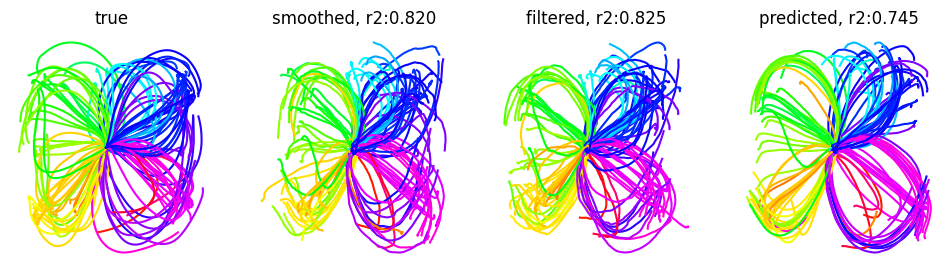

In [88]:
"""plotting"""
n_trials_plot = 125
n_samples_mu_plt = 20

blues = cm.get_cmap("Blues", n_samples_mu_plt)
grays = cm.get_cmap("Greys", n_samples_mu_plt)
yellows = cm.get_cmap("YlOrBr", n_samples_mu_plt)

trial_plt_dx = torch.randperm(n_test_trials)[:n_trials_plot]
reach_angle = torch.atan2(pos_test[:, -1, 0], pos_test[:, -1, 1])
reach_colors = plt.cm.hsv(reach_angle / (2 * np.pi) + 0.5)

with torch.no_grad():
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))

    plot_utils.plot_reaching(axs[0], pos_test[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[1], pos_test_hat_s[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[2], pos_test_hat_f[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[3], pos_test_hat_p[trial_plt_dx], reach_colors[trial_plt_dx])

    axs[0].set_title('true')
    axs[1].set_title(f'smoothed, r2:{r2_test_s:.3f}')
    axs[2].set_title(f'filtered, r2:{r2_test_f:.3f}')
    axs[3].set_title(f'predicted, r2:{r2_test_p:.3f}')
    
    plt.savefig('reach.png')
    plt.show()

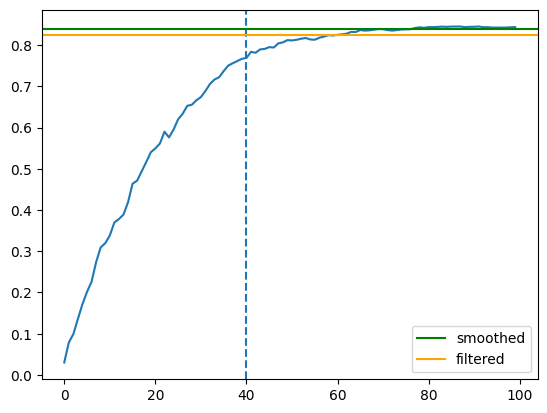

In [89]:
plt.axvline(cfg.n_bins_bhv, linestyle='--')
plt.plot(r2_k_step)
plt.axhline(r2_train, color='green', label='smoothed')
plt.axhline(r2_filter, color='orange', label='filtered')
plt.legend()
plt.savefig('r2')
plt.show()

In [90]:
"""
def get_reaching_dirs(angles):
    
    def get_reaching_dir(angle):
        
        if 0 <= angle < 90:
            return 0
        elif 90 <= angle < 180:
            return 1
        elif 180 <= angle <= 360:
            return 2
        else:
            raise ValueError("Angle out of range")

    return torch.tensor([get_reaching_dir(angle) for angle in angles])


directions = [0, 1, 2]
reach_dirs = get_reaching_dirs(reach_angles_deg)
"""
def get_reaching_dirs(angles):
    
    def get_reaching_dir(angle):
        
        if 350 <= angle < 360 or 0 <= angle < 38:
            return 0
        elif 38 <= angle < 125:
            return 1
        elif 125 <= angle < 175:
            return 2
        elif 175 <= angle < 212:
            return 3
        elif 212 <= angle < 232:
            return 4
        elif 232 <= angle < 280:
            return 5
        elif 280 <= angle <= 329:
            return 6
        elif 329 <= angle <= 350:
            return 7
        else:
            raise ValueError("Angle out of range")
            
    return torch.tensor([get_reaching_dir(angle) for angle in angles])


directions = [0, 1, 2, 3, 4, 5, 6, 7]
reach_dirs = get_reaching_dirs(reach_angles_deg)

In [91]:
def calc_psth(rates, reach_dirs=reach_dirs, directions=directions):
    psth = np.zeros((len(directions), rates.shape[1], rates.shape[2]))

    for i, direction in enumerate(directions):
        mask = reach_dirs == direction
        # We devide by the bin size (in sec) to get the firing rate as the number of spikes per second, not per bin.
        psth[i, :, :] = rates[mask, :, :].mean(axis=0)
    
    return psth


def calc_std_error(model_rates, directions=directions, reach_dirs=reach_dirs):
    
    std_error = []
    for dir_idx, direction in enumerate(directions):
        mask = reach_dirs == direction
        
        model_std = np.std(np.array(model_rates[mask, :, :]), axis=0)
        sample_size = np.array(model_rates[mask, :, :]).shape[0]
        
        std_error = model_std / np.sqrt(sample_size)
        bin_avg_std_error = np.mean(std_error, axis=1)
            
        std_error.append(bin_avg_std_error)
    return np.array(std_error)


def calc_mod_idx(psth):
    """
    returns the total modulation index on neurons, by summing for all directons, for all time bins.
    """
    mi =  np.sum((psth.max(axis=0) - psth.min(axis=0)) / (psth.max(axis=0) + psth.min(axis=0)), axis=0)
    
    return(np.nan_to_num(mi, nan=0))


def calc_var_to_mean_ratio(psth):
    v_m_ratio =  np.sum((psth.var(axis=0)) / (psth.mean(axis=0)), axis=0)
    
    return(np.nan_to_num(v_m_ratio, nan=0))


def calc_model_data_mse(psth):
    rates_mean = rates.numpy().mean(axis=0)
    mse = np.sum(np.sum((psth - rates_mean) ** 2, axis=0), axis=0)
    
    return(np.nan_to_num(mse, nan=0))


def get_index_of_precentile(data, percentile):
    sorted_indices = np.argsort(data)
    data_sorted = data[sorted_indices]
    
    cumulative_sum = np.cumsum(data_sorted)
    threshold = percentile * cumulative_sum[-1]
    
    sorted_index = np.searchsorted(cumulative_sum, threshold)
    
    return sorted_indices[sorted_index]


def get_abs_coeff(clf):
    coefficients = np.abs(clf.coef_)
    
    return np.mean(coefficients, axis=0)


def evaluate_neuron_impact(X_train, X_test, y_train, y_test, feature_idx):

    X_train_reduced = np.delete(X_train, feature_idx, axis=1)
    X_test_reduced = np.delete(X_test, feature_idx, axis=1)

    clf_reduced = Ridge(alpha=0.01)
    clf_reduced.fit(X_train_reduced, y_train)

    return clf_reduced.score(X_test_reduced, y_test)


def get_impact_on_r2(train_rates, test_rates, train_vel, test_vel):
    original_accuracy = clf.score(test_rates.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    impact = []

    for idx in range(test_rates.shape[2]):
        accuracy_without_feature = evaluate_neuron_impact(
            train_rates.reshape(-1, train_rates.shape[2]), test_rates.reshape(-1, test_rates.shape[2]),
            train_vel.reshape(-1, 2), test_vel.reshape(-1, 2),
            idx
        )
        impact.append(original_accuracy - accuracy_without_feature)
        
    return np.array(impact)

In [92]:
data_psth = calc_psth(data_rates, reach_dirs, directions)[directions]
model_psth = calc_psth(model_rates, reach_dirs, directions)[directions]

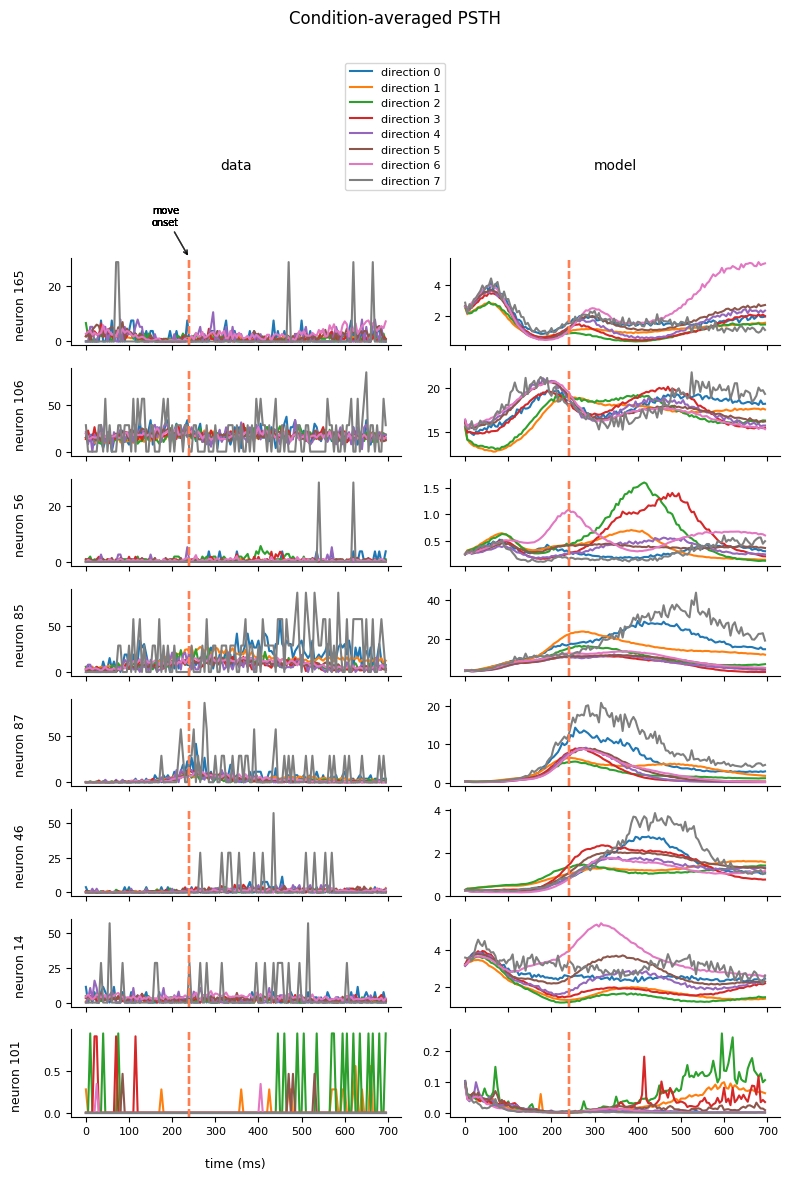

In [93]:
n_neurons_to_plot = 8
neuron_indcs = np.random.choice(range(0, y_valid_obs.shape[2]), size=n_neurons_to_plot, replace=False)

fig, axes = plt.subplots(ncols=2, nrows=n_neurons_to_plot, figsize=(n_neurons_to_plot * 1, n_neurons_to_plot * 1.5), sharex=True)
fig.suptitle(f'Condition-averaged PSTH\n\n\n\n\n\n')

for neuron_dx, neuron in enumerate(neuron_indcs):
    for dir_idx, direction in enumerate(directions):

        axes[0, 0].set_title('data\n\n\n\n\n', fontsize=10)
        axes[neuron_indcs.tolist().index(neuron), 0].plot(
            np.arange(n_bins) * cfg.bin_sz_ms,
            data_psth[dir_idx, :, neuron],
            label=f'direction {direction}' if neuron == neuron_indcs[-1] else '')

        axes[0, 1].set_title('model\n\n\n\n\n', fontsize=10)
        axes[neuron_indcs.tolist().index(neuron), 1].plot(
            np.arange(n_bins) * cfg.bin_sz_ms,
            model_psth[dir_idx, :, neuron]) 
        axes[n_neurons_to_plot-1, 0].set_xlabel('\ntime (ms)' if neuron == neuron_indcs[-1] else None, fontsize=9)
        axes[neuron_indcs.tolist().index(neuron), 0].set_ylabel(f'neuron {neuron+1} \n', fontsize=9)

    for ax_idx, ax in enumerate(axes.flat):
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.axvline(x=48 * cfg.bin_sz_ms, color='coral', linestyle='--')
        #ax.axvline(x=b_test[:, 1].mean(dim=0) * cfg.bin_sz_ms, color='navy', linestyle='--')
        #ax.axvline(x=b_test[:, 2].mean(dim=0) * cfg.bin_sz_ms, color='gold', linestyle='--')

    mark_events_on_psth(axes[0, 0], cfg, b_test)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=1, fontsize=8)
fig.tight_layout()

plt.savefig('output_figs/cond_avg_psth.png')
plt.show()

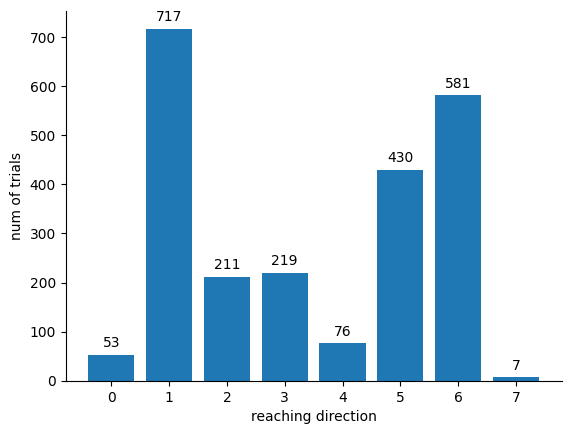

In [94]:
n, bins, patches = plt.hist(reach_dirs, bins=range(len(directions)+1), align='left', rwidth=0.8)
plt.xlabel('reaching direction')
plt.ylabel('num of trials')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('output_figs/conds_counts.png')

for count, bin_edge in zip(n, bins):
    bin_width = bins[1] - bins[0]
    bin_center = bin_edge
    plt.text(
        bin_center, count+10, f'{int(count)}', ha='center', va='bottom', fontsize=10, color='black'
    )
    
plt.show()

In [97]:
def plot_psth(data_psth, model_psth, bhv_bins, clf=clf, directions=directions, n_neurons_to_plot=8, orderby=None):
    """
    Condition-averaged PSTH of the top <n_neurons_to_plot> neurons ordered by <orderby>.
    """
        
    if orderby == 'fr':
        avg_fr = data_rates.numpy().mean(axis=0).mean(axis=0)
        #neuron_indcs = np.array([np.argsort(avg_fr)[-i] for i in range(1, n_neurons_to_plot+1)])
        neuron_indcs = np.array([get_index_of_precentile(avg_fr, precentile) for precentile in np.linspace(1, 0, n_neurons_to_plot)])
        title = 'Condition-averaged PSTH\n(neurons sorted by trial-averaged firing rate)\n\n\n\n'
        filename = 'cond_avg_psth_orderedby_fr.png'

    elif orderby == 'mi':
        mi = calc_mod_idx(data_psth)
        #neuron_indcs = np.array([np.argsort(mi)[-i] for i in range(1, n_neurons_to_plot+1)])
        neuron_indcs = np.array([get_index_of_precentile(mi, precentile) for precentile in np.linspace(1, 0, n_neurons_to_plot)])
        title = 'Condition-averaged PSTH\n(neurons sorted by tuning depth measured by modulation index)\n\n\n\n'
        filename = 'cond_avg_psth_orderedby_mi.png'

    elif orderby == 'vmr':
        vmr = calc_var_to_mean_ratio(data_psth)
        #neuron_indcs = np.array([np.argsort(vmr)[-i] for i in range(1, n_neurons_to_plot+1)])
        neuron_indcs = np.array([get_index_of_precentile(vmr, precentile) for precentile in np.linspace(1, 0, n_neurons_to_plot)])
        title = 'Condition-averaged PSTH\n(neurons sorted by tuning depth measured by variance-to-mean ratio)\n\n\n\n'
        filename = 'cond_avg_psth_orderedby_vmr.png'

    elif orderby == 'mse':
        mse = calc_model_data_mse(data_rates)
        #neuron_indcs = np.array([np.argsort(mse)[-i] for i in range(1, n_neurons_to_plot+1)])
        neuron_indcs = np.array([get_index_of_precentile(mse, precentile) for precentile in np.linspace(1, 0, n_neurons_to_plot)])
        title = 'Condition-averaged PSTH\n(neurons sorted by tuning depth measured by MSE)\n\n\n'
        filename = 'cond_avg_psth_orderedby_mse.png'

    elif orderby == 'r2':
        r2 = get_impact_on_r2(rates_train_s, rates_test_s, vel_train, vel_test)
        #neuron_indcs = np.array([np.argsort(r2)[-i] for i in range(1, n_neurons_to_plot+1)])
        neuron_indcs = np.array([get_index_of_precentile(r2, precentile) for precentile in np.linspace(1, 0, n_neurons_to_plot)])
        title = 'Condition-averaged PSTH\n(neurons sorted by impact on velocity decoding measured by reduction in accuracy due to dropping each neuron)\n\n\n\n'
        filename = 'cond_avg_psth_orderedby_r2.png'

    elif orderby == 'coeff':
        coeffs = get_abs_coeff(clf)
        #neuron_indcs = np.array([np.argsort(coeffs)[-i] for i in range(1, n_neurons_to_plot+1)])
        neuron_indcs = np.array([get_index_of_precentile(coeffs, precentile) for precentile in np.linspace(1, 0, n_neurons_to_plot)])
        title = 'Condition-averaged PSTH\n(neurons sorted by impact on velocity decoding measured by the abs value of coefficients\nin the decoder)\n\n\n\n'
        filename = 'cond_avg_psth_orderedby_coeff.png'

    elif orderby is None:
        neuron_indcs = np.random.choice(range(0, y_valid_obs.shape[2]), size=n_neurons_to_plot, replace=False)
        title = 'Condition-averaged PSTH\n\n\n\n'
        filename = 'cond_avg_psth.png'

    else:
        print("Valid options for ordering neurons: 'fr', 'mi', 'vmr', 'r2', 'mse', 'coeff', None")
        pass

    fig, axes = plt.subplots(ncols=len(directions), nrows=n_neurons_to_plot, figsize=(12, 12), sharex=True)
    fig.suptitle(title)
    colors = sns.color_palette("viridis", len(directions)).as_hex()

    for neuron_idx, neuron in enumerate(neuron_indcs):
        for dir_idx, direction in enumerate(directions):

            std_error = np.std((model_rates[reach_dirs == direction][:, :, neuron]).numpy(), axis=0) / np.sqrt(model_rates[reach_dirs == direction][:, :, neuron].shape[0])

            axes[0, dir_idx].set_title(f'\ndirection {dir_idx}\n\n\n\n\n', fontsize=8)

            axes[neuron_idx, dir_idx].plot(
                np.arange(cfg.n_bins) * cfg.bin_sz_ms,
                data_psth[dir_idx, :, neuron],
                #color=colors[dir_idx],
                color='black',
                alpha=1.0,
                linewidth=0.8,
                label=f'data' if neuron == neuron_indcs[-1] and direction == directions[-1] else ''
            )

            axes[neuron_idx, dir_idx].plot(
                np.arange(cfg.n_bins) * cfg.bin_sz_ms,
                model_psth[dir_idx, :, neuron],
                #color=colors[dir_idx],
                color='magenta',
                linewidth=0.6,
                alpha=1.0,
                label=f'model' if neuron == neuron_indcs[-1] and direction == directions[-1] else ''
            )

            axes[neuron_idx, dir_idx].fill_between(
                np.arange(cfg.n_bins) * cfg.bin_sz_ms,
                model_psth[dir_idx, :, neuron] - std_error,
                model_psth[dir_idx, :, neuron] + std_error,
                color='pink',
                alpha=0.5,
                label='model std error' if neuron == neuron_indcs[-1] and dir_idx == len(directions)-1 else ''
            )
            
            #if neuron_idx == 0 and dir_idx == 0:
            #    mark_events_on_psth(axes[neuron_idx, dir_idx], cfg, bhv_bins)

            axes[n_neurons_to_plot-1, 0].set_xlabel('time (ms)' if neuron == neuron_indcs[-1] else None, fontsize=6)
            axes[neuron_indcs.tolist().index(neuron), 0].set_ylabel(f'neuron {neuron+1}', fontsize=6)

            ymax = max(np.max(data_psth[:, :, neuron].flatten()), np.max(model_psth[:, :, neuron].flatten())) * 1.1
            axes[neuron_idx, dir_idx].set_ylim(0, ymax)

        for ax in axes.flat:
            ax.tick_params(axis='x', labelsize=6)
            ax.tick_params(axis='y', labelsize=6)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            ax.axvline(x=bhv_bins[:, 0].mean(dim=0) * cfg.bin_sz_ms, color='coral', linestyle='--', linewidth=0.5)
            ax.axvline(x=bhv_bins[:, 1].mean(dim=0) * cfg.bin_sz_ms, color='navy', linestyle='--', linewidth=0.5)
            ax.axvline(x=bhv_bins[:, 2].mean(dim=0) * cfg.bin_sz_ms, color='gold', linestyle='--', linewidth=0.5)
            
    mark_events_on_psth(axes[0, 0], cfg, bhv_bins)
    
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=1, fontsize=8)
    fig.tight_layout()

    plt.savefig(f'output_figs/data_model_{filename}')
    plt.show()

    fig, axes = plt.subplots(ncols=len(directions), nrows=n_neurons_to_plot, figsize=(12,  12), sharex=True)
    fig.suptitle(title)
    colors = sns.color_palette("viridis", len(directions)).as_hex()

    for neuron_idx, neuron in enumerate(neuron_indcs):
        for dir_idx, direction in enumerate(directions):

            with torch.no_grad():
                std_error = np.std((model_rates[reach_dirs == direction][:, :, neuron]).numpy(), axis=0) / np.sqrt(model_rates[reach_dirs == direction][:, :, neuron].shape[0])

            axes[0, dir_idx].set_title(f'\ndirection {dir_idx}\n\n\n\n\n', fontsize=8)

            axes[neuron_idx, dir_idx].plot(
                np.arange(cfg.n_bins) * cfg.bin_sz_ms,
                model_psth[dir_idx, :, neuron],
                #color=colors[dir_idx],
                color='purple',
                linewidth=1.0,
                alpha=0.8,
                label=f'model' if neuron == neuron_indcs[-1] and direction == directions[-1] else ''
            )

            axes[neuron_idx, dir_idx].fill_between(
                np.arange(cfg.n_bins) * cfg.bin_sz_ms,
                model_psth[dir_idx, :, neuron] - std_error,
                model_psth[dir_idx, :, neuron] + std_error,
                color='pink',
                alpha=0.5,
                label='std error' if neuron == neuron_indcs[-1] and dir_idx == len(directions)-1 else ''
            )
            
            #if neuron_idx == 0 and dir_idx == 0:
            #    mark_events_on_psth(axes[neuron_idx, dir_idx], cfg, bhv_bins)

            axes[n_neurons_to_plot-1, 0].set_xlabel('time (ms)' if neuron == neuron_indcs[-1] else None, fontsize=6)
            axes[neuron_indcs.tolist().index(neuron), 0].set_ylabel(f'neuron {neuron+1}', fontsize=6)

            ymax = np.max(model_psth[:, :, neuron].flatten()) * 1.1
            axes[neuron_idx, dir_idx].set_ylim(0, ymax)

        for ax in axes.flat:
            ax.tick_params(axis='x', labelsize=6)
            ax.tick_params(axis='y', labelsize=6)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            ax.axvline(x=bhv_bins[:, 0].mean(dim=0) * cfg.bin_sz_ms, color='coral', linestyle='--', linewidth=0.5)
            ax.axvline(x=bhv_bins[:, 1].mean(dim=0) * cfg.bin_sz_ms, color='navy', linestyle='--', linewidth=0.5)
            ax.axvline(x=bhv_bins[:, 2].mean(dim=0) * cfg.bin_sz_ms, color='gold', linestyle='--', linewidth=0.5)
            
    mark_events_on_psth(axes[0, 0], cfg, bhv_bins)

    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=1, fontsize=8)
    fig.tight_layout()

    plt.savefig(f'output_figs/model_{filename}')
    plt.show()

    fig, axes = plt.subplots(ncols=len(directions), nrows=n_neurons_to_plot, figsize=(12,  12), sharex=True)
    fig.suptitle(title)
    colors = sns.color_palette("viridis", len(directions)).as_hex()

    for neuron_idx, neuron in enumerate(neuron_indcs):
        for dir_idx, direction in enumerate(directions):

            with torch.no_grad():
                std = np.std((data_rates[reach_dirs == direction][:, :, neuron]).numpy(), axis=0)

            axes[0, dir_idx].set_title(f'\ndirection {dir_idx}\n\n\n\n\n\n', fontsize=8)

            axes[neuron_idx, dir_idx].plot(
                np.arange(cfg.n_bins) * cfg.bin_sz_ms,
                data_psth[dir_idx, :, neuron],
                #color=colors[dir_idx],
                color='green',
                linewidth=1.0,
                alpha=0.8,
                label=f'data' if neuron == neuron_indcs[-1] and direction == directions[-1] else ''
            )

            axes[neuron_idx, dir_idx].fill_between(
                np.arange(cfg.n_bins) * cfg.bin_sz_ms,
                data_psth[dir_idx, :, neuron] - std/2,
                data_psth[dir_idx, :, neuron] + std/2,
                color='skyblue',
                alpha=0.5,
                label='std' if neuron == neuron_indcs[-1] and dir_idx == len(directions)-1 else ''
            )
            
            #if neuron_idx == 0 and dir_idx == 0:
            #    mark_events_on_psth(axes[neuron_idx, dir_idx], cfg, bhv_bins)

            axes[n_neurons_to_plot-1, 0].set_xlabel('time (ms)' if neuron == neuron_indcs[-1] else None, fontsize=6)
            axes[neuron_indcs.tolist().index(neuron), 0].set_ylabel(f'neuron {neuron+1}', fontsize=6)

            ymax = np.max(data_psth[:, :, neuron].flatten()) * 1.1
            axes[neuron_idx, dir_idx].set_ylim(0, ymax)

        for ax in axes.flat:
            ax.tick_params(axis='x', labelsize=6)
            ax.tick_params(axis='y', labelsize=6)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            ax.axvline(x=bhv_bins[:, 0].mean(dim=0) * cfg.bin_sz_ms, color='coral', linestyle='--', linewidth=0.5)
            ax.axvline(x=bhv_bins[:, 1].mean(dim=0) * cfg.bin_sz_ms, color='navy', linestyle='--', linewidth=0.5)
            ax.axvline(x=bhv_bins[:, 2].mean(dim=0) * cfg.bin_sz_ms, color='gold', linestyle='--', linewidth=0.5)
            
    mark_events_on_psth(axes[0, 0], cfg, bhv_bins)

    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=1, fontsize=8)
    fig.tight_layout()

    plt.savefig(f'output_figs/data_{filename}')
    plt.show()

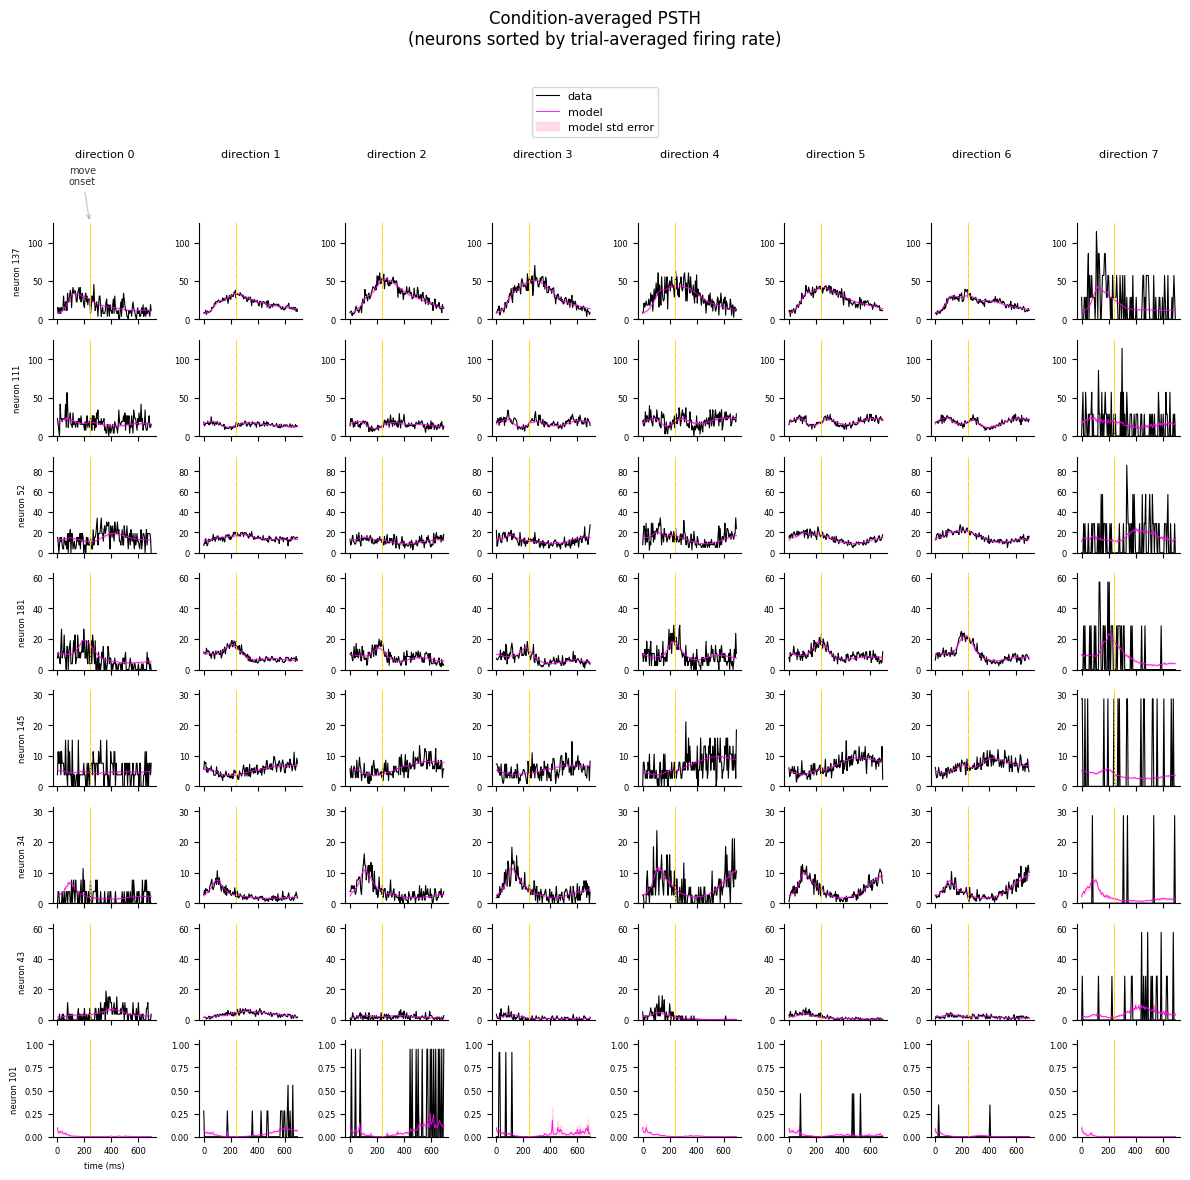

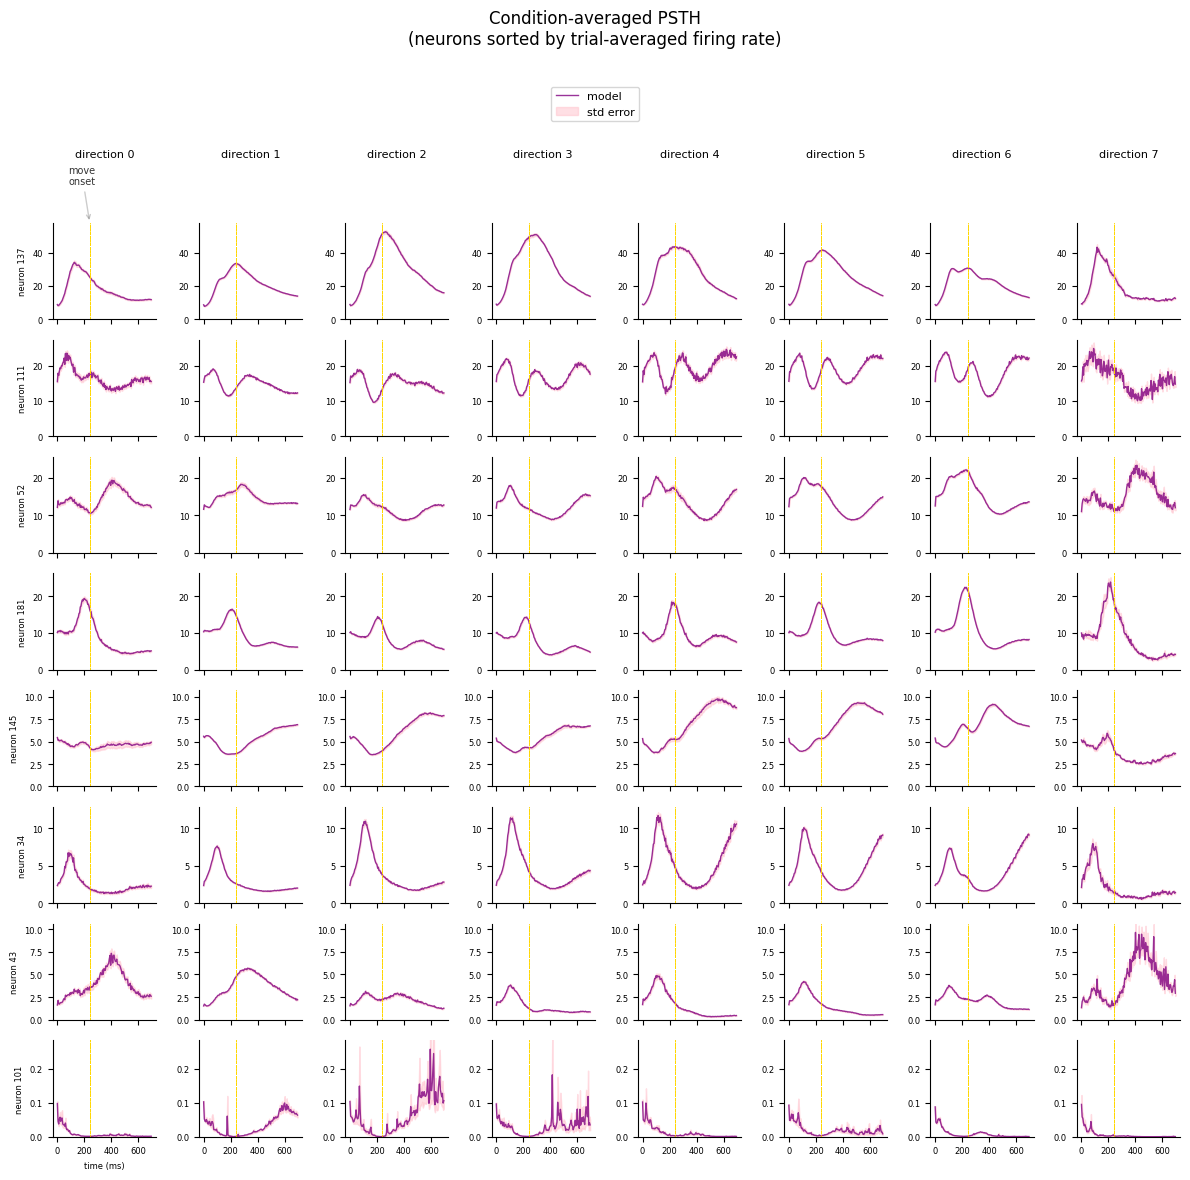

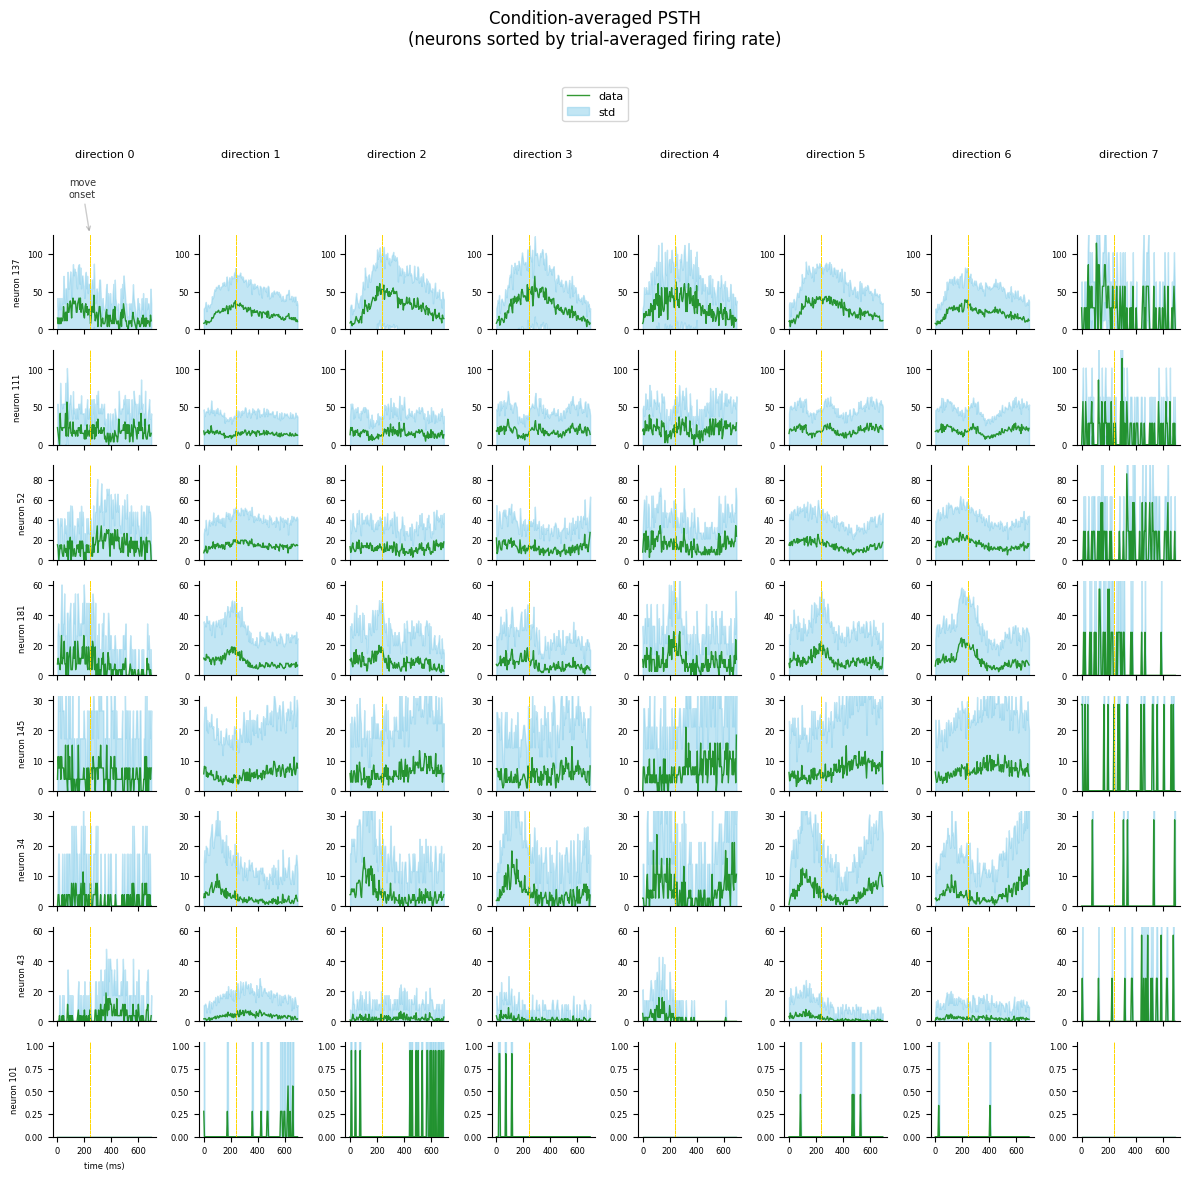

In [98]:
plot_psth(data_psth, model_psth, b_test, orderby="fr")

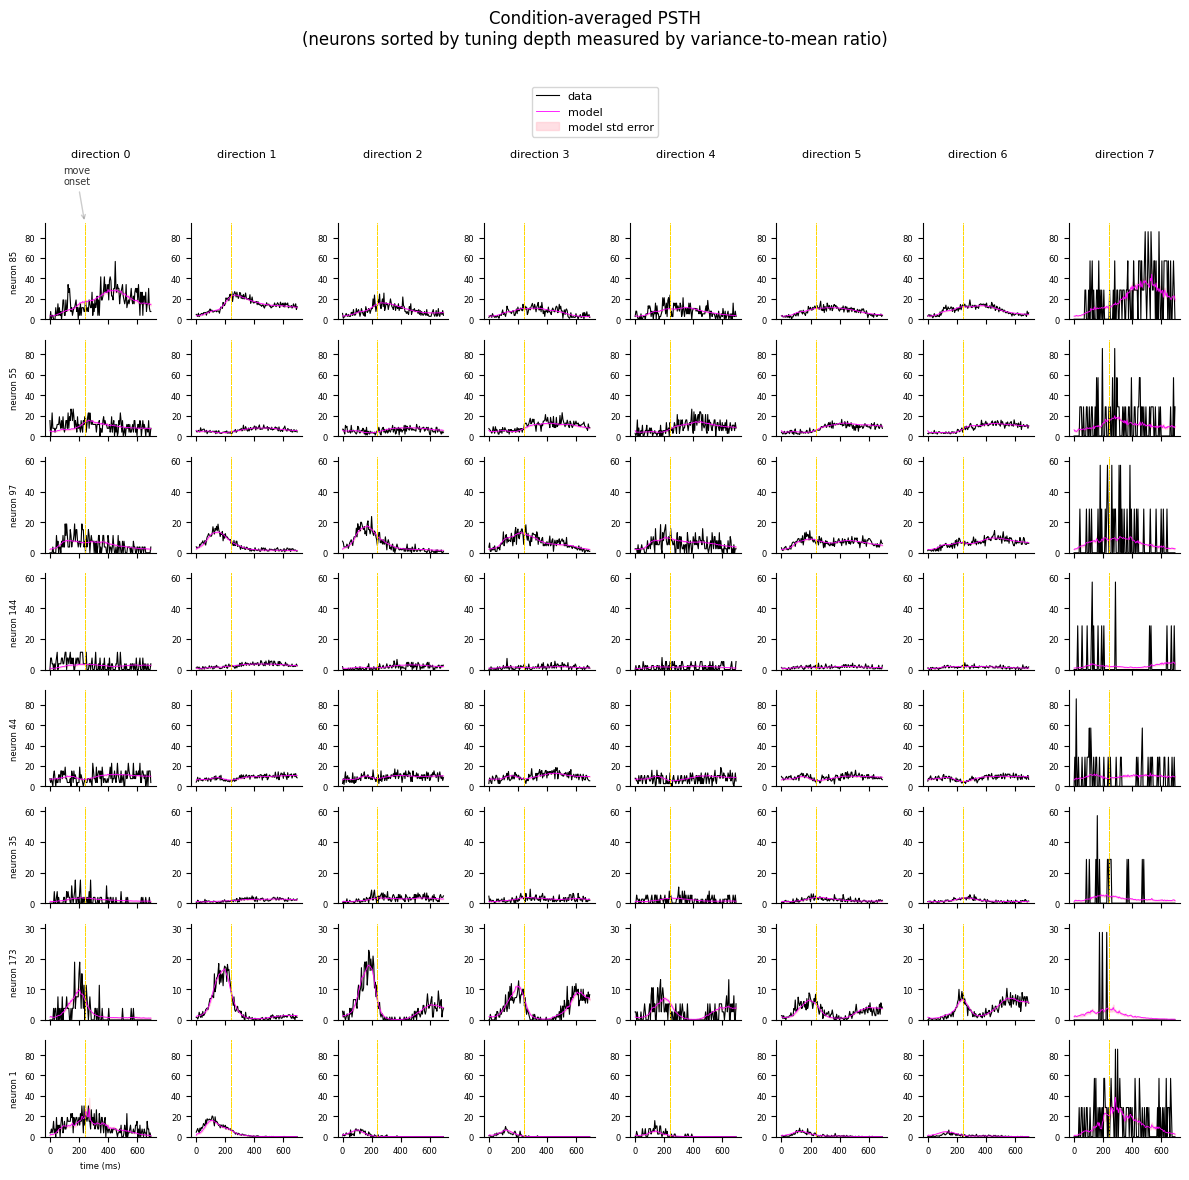

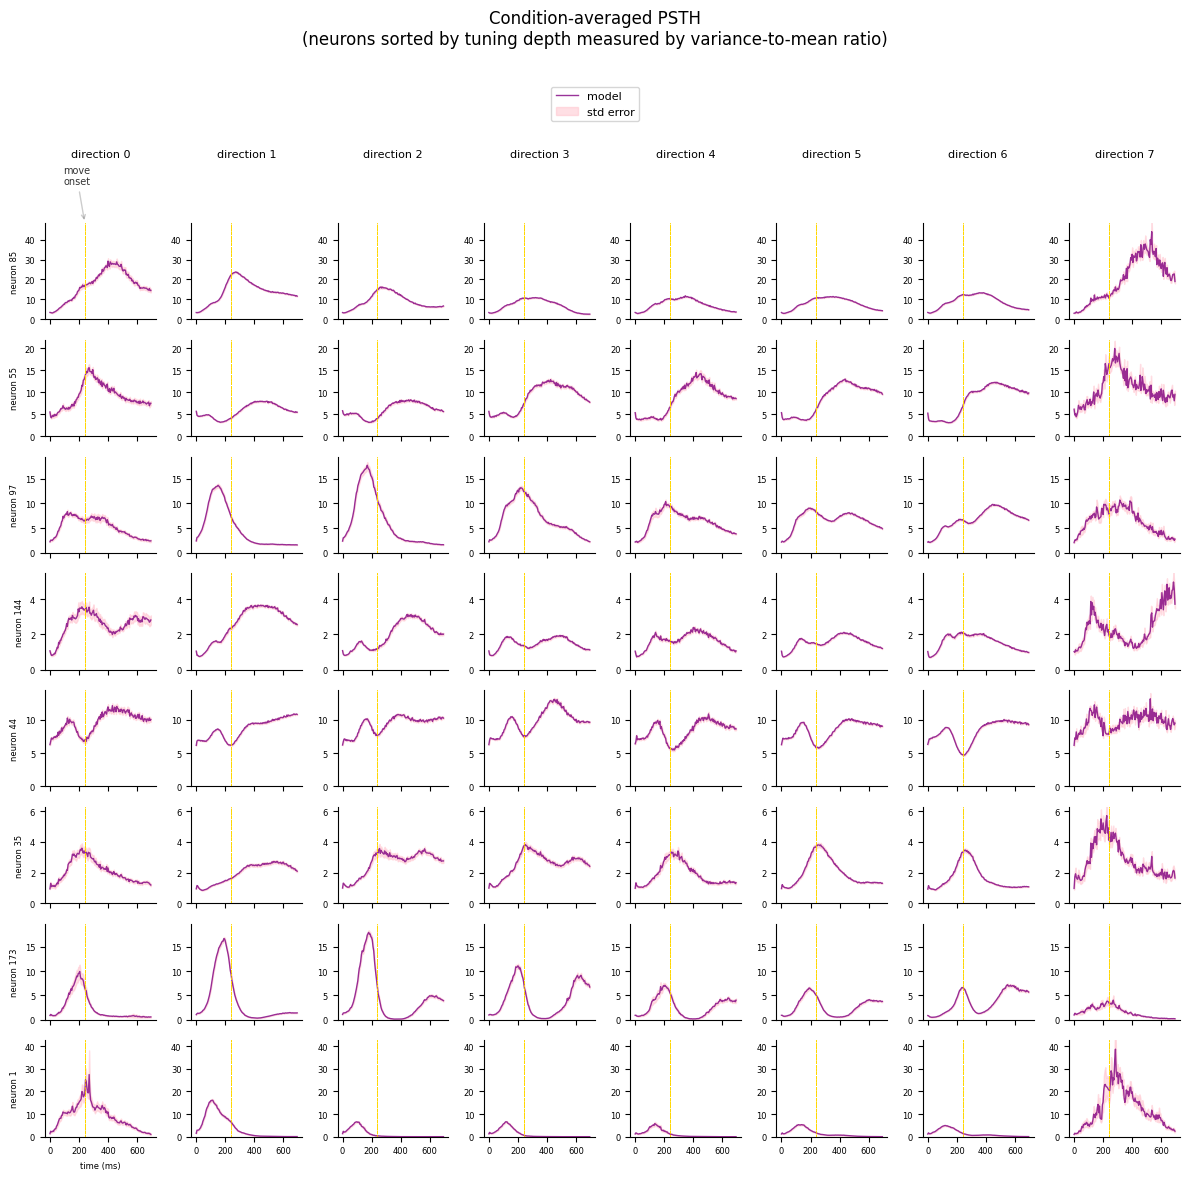

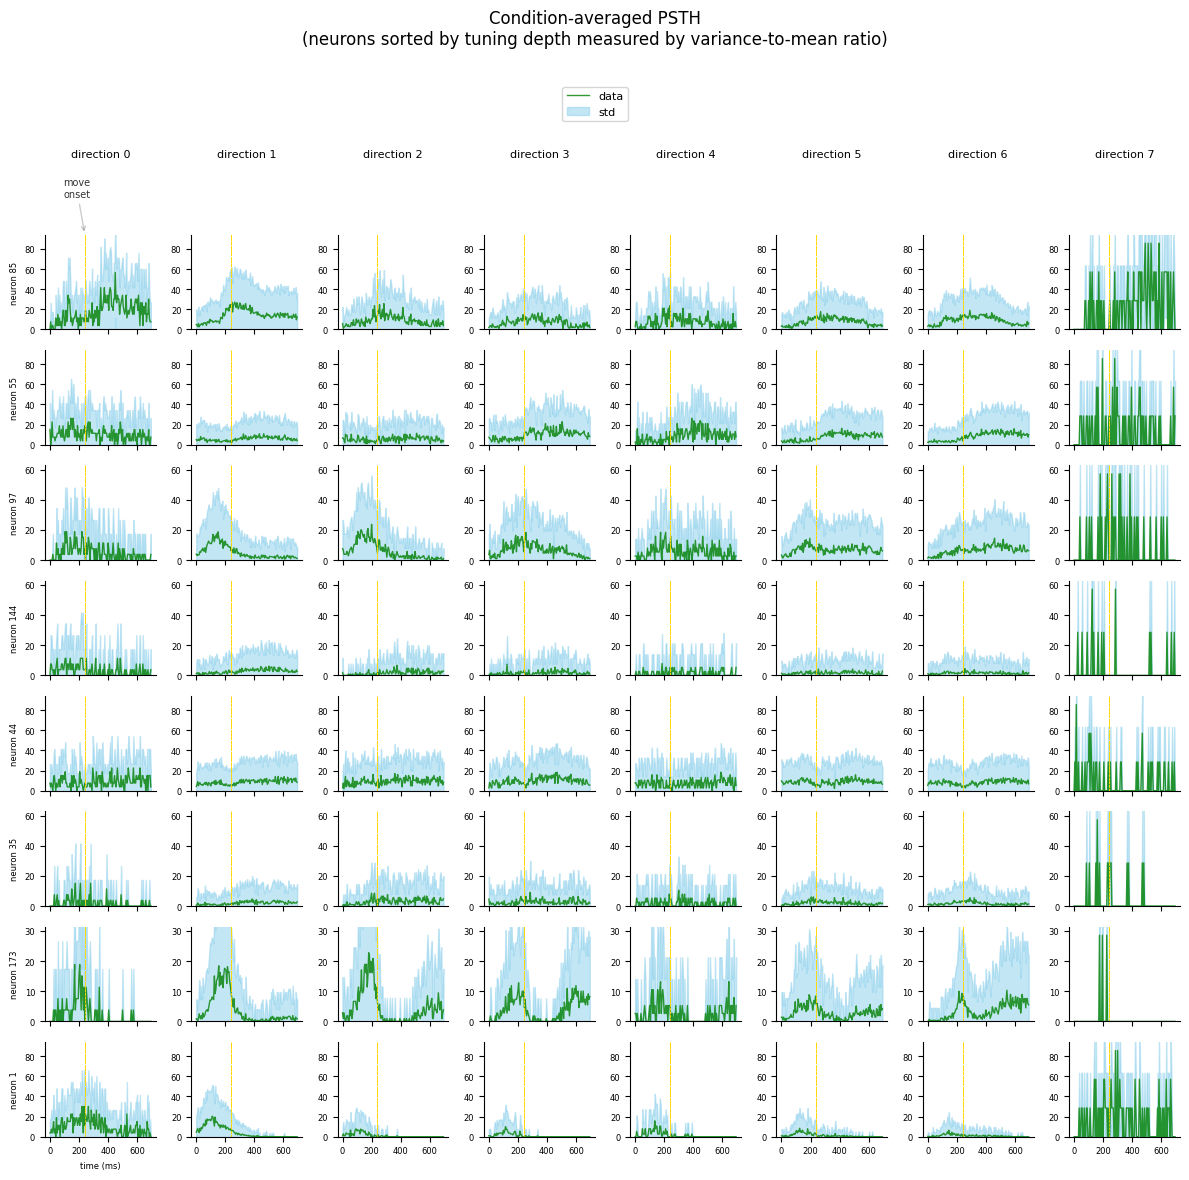

In [99]:
plot_psth(data_psth, model_psth, b_test, orderby='vmr')

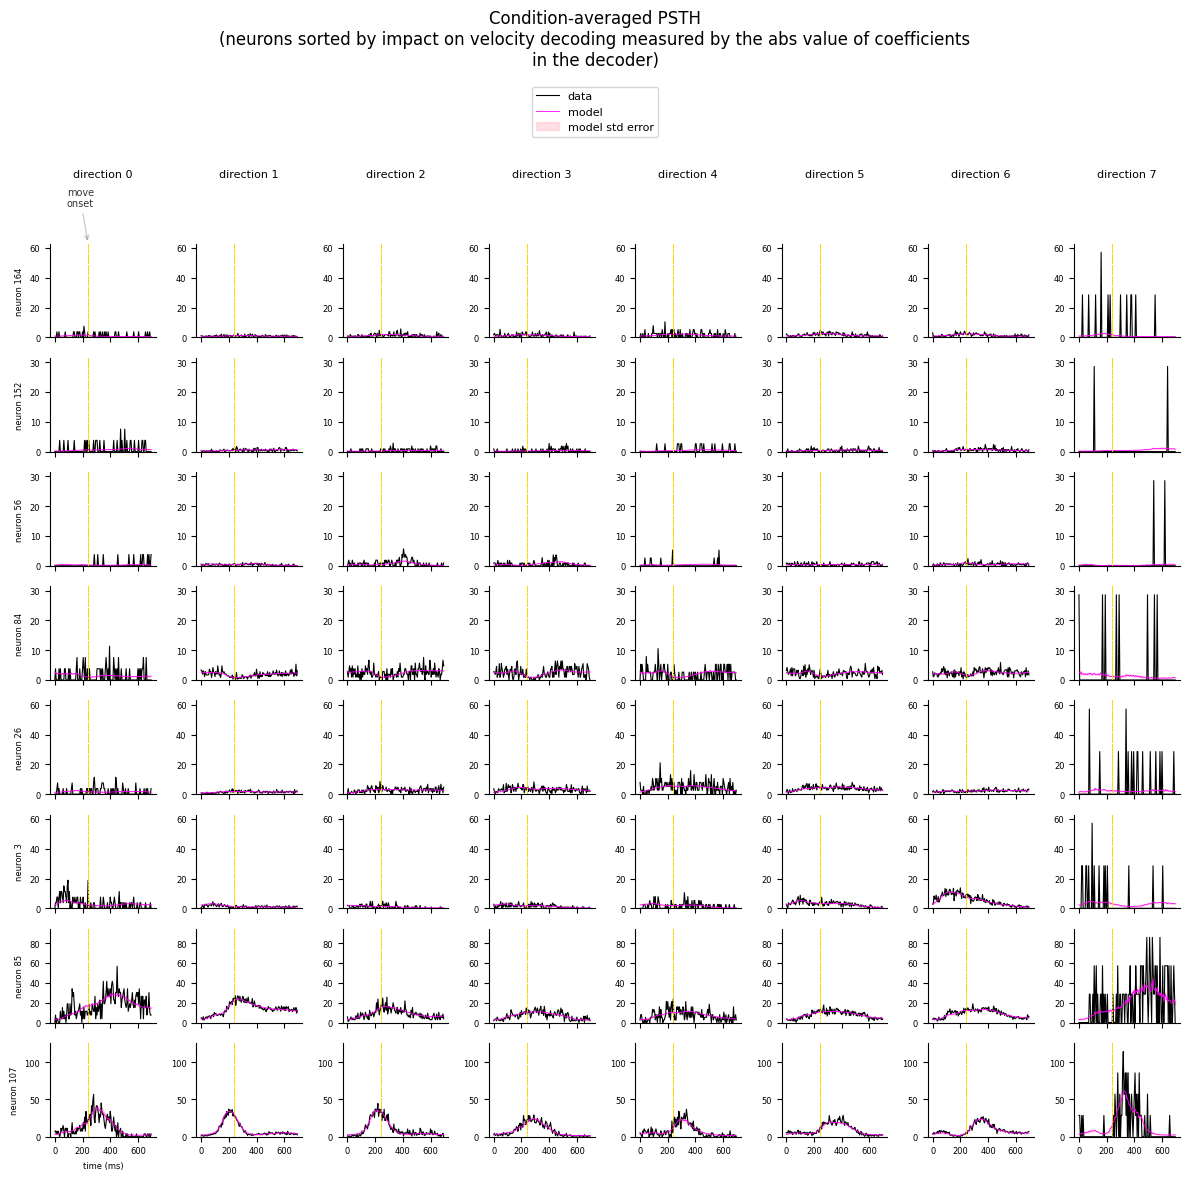

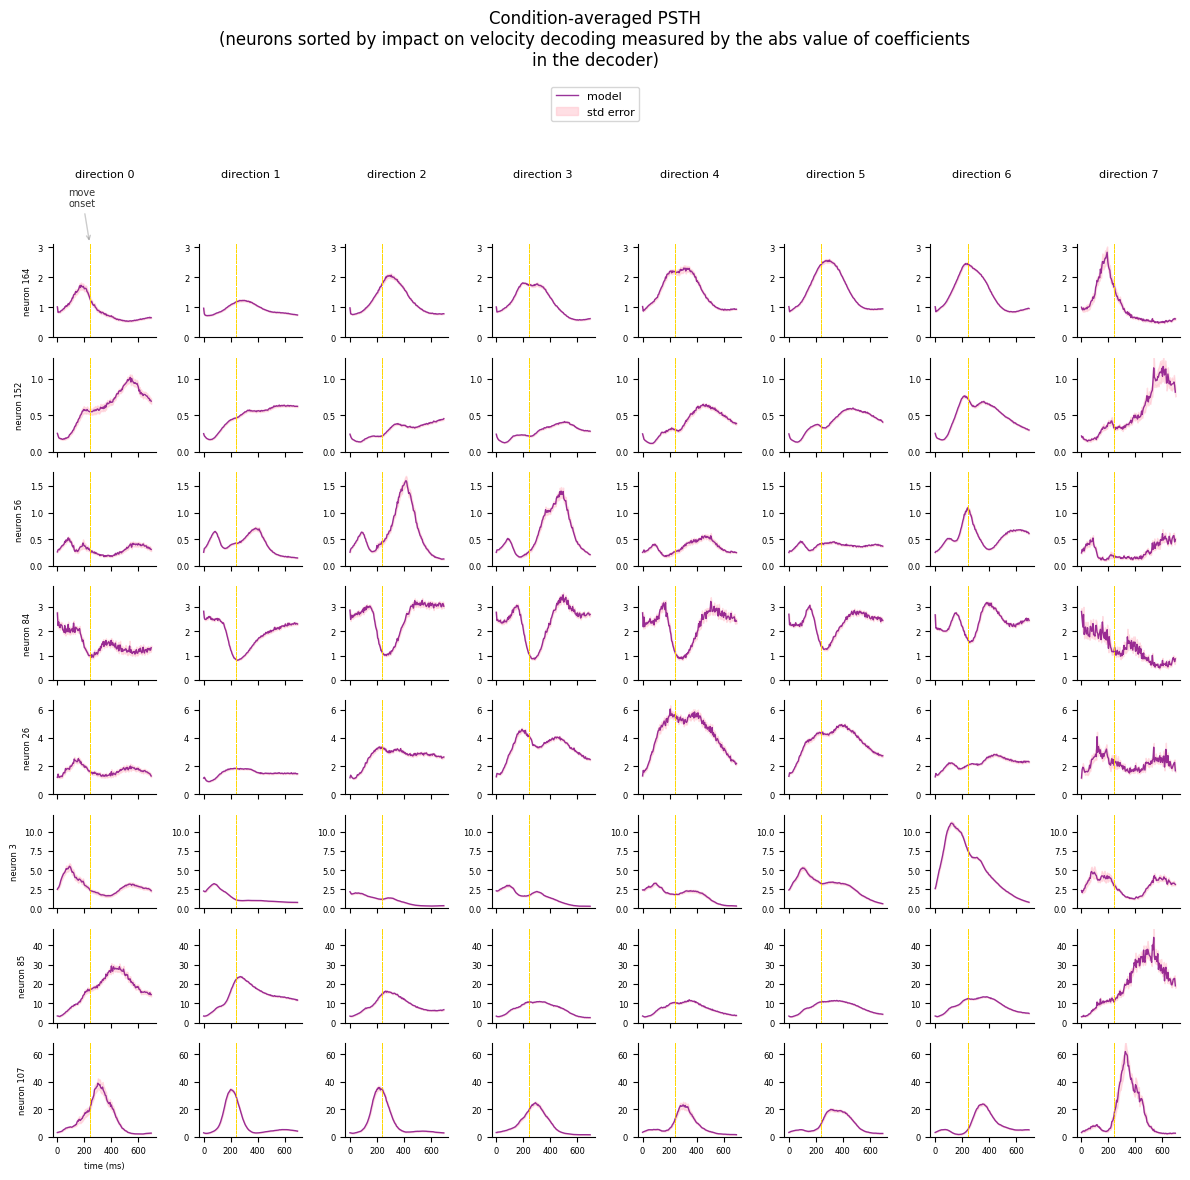

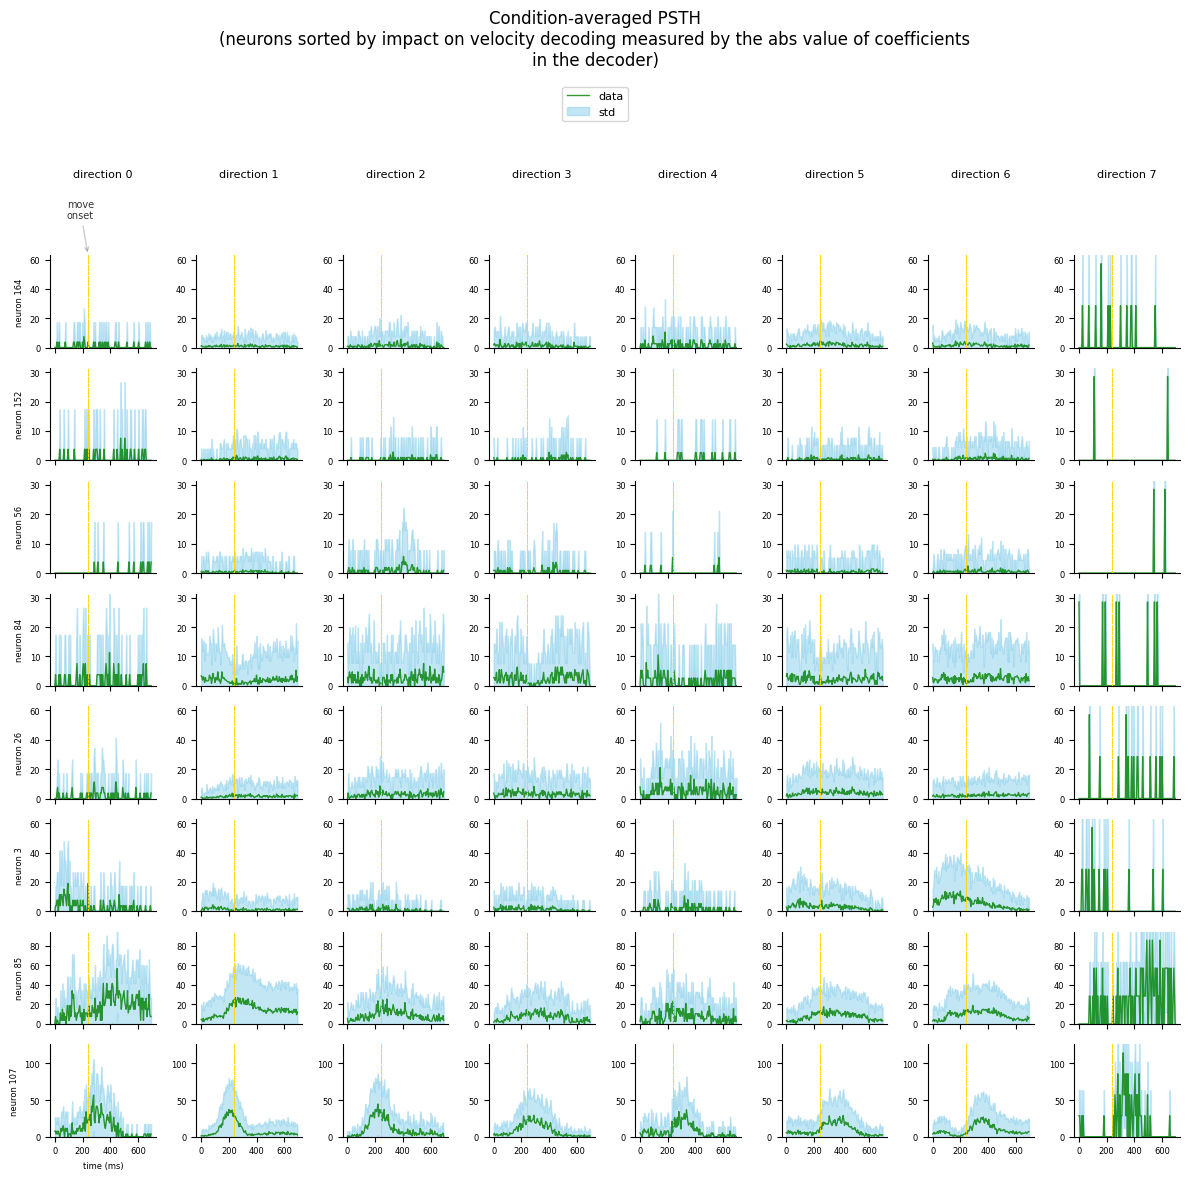

In [100]:
plot_psth(data_psth, model_psth, b_test, orderby='coeff')